# M2177.003100 Deep Learning <br> Assignment #4 Implementing Variational AutoEncoder - part1 MNIST data

Copyright (C) Data Science Laboratory, Seoul National University. This material is for educational uses only. Some contents are based on the material provided by other paper/book authors and may be copyrighted by them. Written by Chaehun Shin, September

In this notebook, you will learn how to implement Variational AutoEncoder(VAEs). <br>
The goal here is to build VAEs that draw a digit(MNIST data). <br> 

**Note**: certain details are missing or ambiguous on purpose, in order to test your knowledge on the related materials. However, if you really feel that something essential is missing and cannot proceed to the next step, then contact the teaching staff with clear description of your problem.

### Submitting your work:
<font color=red>**DO NOT clear the final outputs**</font> so that TAs can grade both your code and results.  
Once you have done **all parts**, run the *CollectSubmission.sh* script with your **Team number** as input argument. <br>
This will produce a zipped file called *[Your team number].zip*. Please submit this file on ETL. &nbsp;&nbsp; (Usage: ./*CollectSubmission.sh* &nbsp; Team_#)

### Some helpful tutorials and references for assignment #1:
- [1] TensorFlow official tutorials. [[link]](https://www.tensorflow.org/get_started/get_started)
- [2] Stanford CS231n lectures. [[link]](http://cs231n.stanford.edu/)
- [3] Kingma, Diederik P., and Max Welling. "Auto-encoding variational bayes." arXiv preprint arXiv:1312.6114 (2013).
- [4] Doersch, Carl. "Tutorial on variational autoencoders." arXiv preprint arXiv:1606.05908 (2016).
- [5] Kingma, Diederik P., and Max Welling. "An Introduction to Variational Autoencoders." arXiv preprint arXiv:1906.02691 (2019).

## 0. Download and load MNIST datasets
The MNIST dataset will be downloaded into the 'data' directory. If you want to change the directory where the data is saved, change mnist_data_dir with where you want. <br>

In [1]:
from download import *
import os
from utils import load_mnist
mnist_data_dir = './data'
prepare_data_dir(mnist_data_dir)
download_mnist(mnist_data_dir)
data_array , data_y = load_mnist(os.path.join(mnist_data_dir,'mnist'))
print(data_array.shape)
print(data_y.shape)

Found MNIST - skip
(70000, 28, 28, 1)
(70000, 10)


## <a name="1"></a> 1. Build a network

In this section, you will implement neural networks for (1)encoder $q_\phi(z \mid x)$ to encode latent variable distribution from the image of digits (2)decoder $p_\theta(x \mid z)$ to reconstruct the image of digits from the sample of latent variable distribution. You can use some function in *ops.py* or you can make it as you want. Just write the code in whatever way you find most clear.

In [2]:
from ops import conv2d
from ops import lrelu
from ops import de_conv
from ops import fully_connect
from ops import conv_cond_concat
from ops import batch_normal

import tensorflow as tf
import numpy as np

It is time for an encoder. It takes img_data, img_dim(should be 28\*28\*1=784 here), latent_dim(dimension of the z). It should return the latent variable distribution with the dimension of latent_dim. <br>
Because we model the latent variable distribution as multivariate Gaussian, we can make the distribution with only mean and covariance matrix. Also as we model each latent variable as independent, covariance matrix becomes a diagonal matrix and we need only (latent_dim) number elements. so we make outputs as 2 (latent_dim) dimension vectors from encoder function with neural network. I recommend to use logvar not variance itself because of scalability.

<img src='./pictures/encoder.png'>

Maybe you can use two neural networks for mean and logvar vectors. However it is recommended to use only one neural network with two last branches.<br> 
For example, if you use 5 layer networks, first 4 layers are shared and there are 2 5th layer each corresponding to mean and logvar.

In [3]:
def encoder(img_data, img_dim=784, latent_dim=10, reuse=False):
    with tf.variable_scope('enc', reuse=reuse):
        ### ToDo ###
        
        # 1st hidden layer
        flatten_ = tf.contrib.layers.flatten(img_data)
        enlayer1 = tf.contrib.layers.fully_connected(flatten_, 128, scope='enlayer1', activation_fn=tf.nn.relu)
        enlayer1 = tf.nn.dropout(enlayer1, 1.0)

        # 2nd hidden layer
        enlayer2 = tf.contrib.layers.fully_connected(enlayer1, 64, scope='enlayer2', activation_fn=tf.nn.tanh)
        enlayer2 = tf.nn.dropout(enlayer2, 1.0)

        # 3rd hidden layer
        logits = tf.contrib.layers.fully_connected(enlayer2, latent_dim + latent_dim, scope='logits')

        # The mean parameter is unconstrained
        mean = logits[:, :latent_dim]
        # The standard deviation must be positive.
        # Parameterize with a softplus and add a small epsilon for numerical stability
        logvar = 1e-6 + tf.nn.softplus(logits[:, latent_dim:])
        
    return mean, logvar

Now, it's time for a decoder model. It takes sample of the latent variable distribution(z), latent_dim(dimension of the latent variable), and img_dim(28\*28\*1 here). It should return the reconstruction of the original image as x_hat. <br>
Decoder models the likelihood distributions and in here, we model each pixel as Bernoulli distribution(So we use binary cross entropy as loss function). So **you should use the sigmoid function to make the output as probability in [0, 1]**

<img src='./pictures/decoder.png'>

Note that you should define Tensorflow Variables within the variable scope again.

In [4]:
def decoder(z, latent_dim=10, img_dim=784, reuse=False):
    with tf.variable_scope('dec', reuse=reuse):
        ### ToDo ###
        # 1st hidden layer
        delayer1 = tf.contrib.layers.fully_connected(z, 64, scope='delayer1', activation_fn=tf.nn.tanh)
        delayer1 = tf.nn.dropout(delayer1, keep_prob=1.0)

        # 2nd hidden layer
        delayer2 = tf.contrib.layers.fully_connected(delayer1, 128, scope='delayer2', activation_fn=tf.nn.relu)
        delayer2 = tf.nn.dropout(delayer2, keep_prob=1.0)

        # 3rd hidden layer
        delayer3 = tf.contrib.layers.fully_connected(delayer2,img_dim, scope='delayer3', activation_fn=tf.nn.sigmoid)

        logits = tf.reshape(delayer3, [-1,img_dim])
    return logits
    


## <a name="2"></a> 2. Build a main part and train it

In this section, you will implement the main part. You should define the loss function and reparameterization trick (TODO part). Then run the code and check the model reconstructs a digit.

When you are done, run the following to check your implementations.

Following code will make 'samples_for_test/vae_mnist' directory that resulting image will be saved in. You can change the directory as you want.

Also, you can change all other hyperparameters such as learning rate, batch size. But be sure to define **batch size bigger than 16**.(Because, we visualize 16 images per batch in training time.)

In [5]:
from utils import load_mnist
from utils import save_images
from utils import show_images
from utils import vis_square
from utils import sample_label
from utils import getNext_batch
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2 
import os

learning_rate = 1e-4
batch_size = 128
EPOCH = 1000
loss_step    = 500
display_step = 2500
latent_channel=16
img_channel = 1
output_size = 28
sample_dir = 'samples_for_test/vae_mnist'

if os.path.exists(sample_dir) == False:
    os.makedirs(sample_dir)

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Because sampling can't be differentiated, it needs some tricks called as reparameterization trick.<br>
First, epsilon is sampled from unit Gaussian distribution with latent_dim. Then, scale and shift it by using mean and logvar.<br>
Because sampling is out of graph, gradient can be flowed through all paths and encoder/decoder are trained end-to-end.

<img src='./pictures/reparameterization.png'>
Left image is original version and right image is representation by using reparameterization trick.

Results are visualized in order of original image, reconstructed image, generated image from the left.

In [6]:
tf.reset_default_graph()

Tensor("enc/strided_slice:0", shape=(?, 16), dtype=float32)
Tensor("enc/add:0", shape=(?, 16), dtype=float32)
Tensor("Placeholder_1:0", shape=(?, 16), dtype=float32)


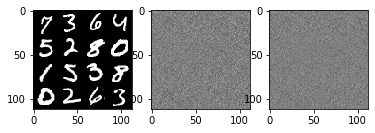

<Epoch:1/1000, Step:500/545>total_loss: 222.0275, kl_loss: 14.4382, recon_loss: 207.5893
<Epoch:2/1000, Step:455/545>total_loss: 219.2480, kl_loss: 11.9814, recon_loss: 207.2667
<Epoch:3/1000, Step:410/545>total_loss: 216.8700, kl_loss: 11.9099, recon_loss: 204.9601
<Epoch:4/1000, Step:365/545>total_loss: 203.8247, kl_loss: 11.4444, recon_loss: 192.3803
<Epoch:5/1000, Step:320/545>total_loss: 211.0497, kl_loss: 11.5020, recon_loss: 199.5477


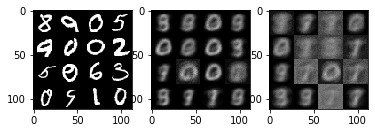

<Epoch:6/1000, Step:275/545>total_loss: 192.3955, kl_loss: 11.5529, recon_loss: 180.8426
<Epoch:7/1000, Step:230/545>total_loss: 198.5362, kl_loss: 13.1478, recon_loss: 185.3884
<Epoch:8/1000, Step:185/545>total_loss: 191.1670, kl_loss: 13.8701, recon_loss: 177.2969
<Epoch:9/1000, Step:140/545>total_loss: 188.3244, kl_loss: 13.4903, recon_loss: 174.8341
<Epoch:10/1000, Step:095/545>total_loss: 181.1673, kl_loss: 15.1457, recon_loss: 166.0216


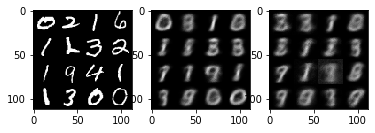

<Epoch:11/1000, Step:050/545>total_loss: 193.1773, kl_loss: 14.0255, recon_loss: 179.1518
<Epoch:12/1000, Step:005/545>total_loss: 184.9669, kl_loss: 15.2011, recon_loss: 169.7658
<Epoch:12/1000, Step:505/545>total_loss: 186.3095, kl_loss: 16.4439, recon_loss: 169.8655
<Epoch:13/1000, Step:460/545>total_loss: 184.0584, kl_loss: 16.2407, recon_loss: 167.8177
<Epoch:14/1000, Step:415/545>total_loss: 187.5743, kl_loss: 17.8246, recon_loss: 169.7496


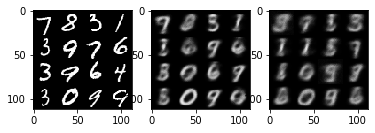

<Epoch:15/1000, Step:370/545>total_loss: 178.9862, kl_loss: 16.9826, recon_loss: 162.0036
<Epoch:16/1000, Step:325/545>total_loss: 186.3990, kl_loss: 17.4879, recon_loss: 168.9111
<Epoch:17/1000, Step:280/545>total_loss: 175.1011, kl_loss: 17.0977, recon_loss: 158.0033
<Epoch:18/1000, Step:235/545>total_loss: 179.5693, kl_loss: 17.7913, recon_loss: 161.7780
<Epoch:19/1000, Step:190/545>total_loss: 179.8073, kl_loss: 17.1271, recon_loss: 162.6802


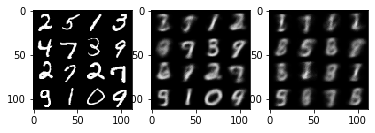

<Epoch:20/1000, Step:145/545>total_loss: 181.5636, kl_loss: 18.5456, recon_loss: 163.0181
<Epoch:21/1000, Step:100/545>total_loss: 179.8827, kl_loss: 19.0133, recon_loss: 160.8694
<Epoch:22/1000, Step:055/545>total_loss: 174.3893, kl_loss: 17.8167, recon_loss: 156.5726
<Epoch:23/1000, Step:010/545>total_loss: 179.0011, kl_loss: 19.6979, recon_loss: 159.3032
<Epoch:23/1000, Step:510/545>total_loss: 177.6906, kl_loss: 18.4492, recon_loss: 159.2414


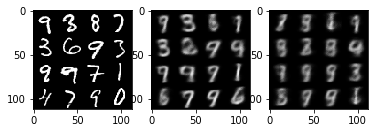

<Epoch:24/1000, Step:465/545>total_loss: 177.5735, kl_loss: 18.4145, recon_loss: 159.1590
<Epoch:25/1000, Step:420/545>total_loss: 174.0519, kl_loss: 19.0744, recon_loss: 154.9775
<Epoch:26/1000, Step:375/545>total_loss: 178.1584, kl_loss: 20.5511, recon_loss: 157.6074
<Epoch:27/1000, Step:330/545>total_loss: 189.0869, kl_loss: 20.4081, recon_loss: 168.6788
<Epoch:28/1000, Step:285/545>total_loss: 179.7123, kl_loss: 19.5226, recon_loss: 160.1897


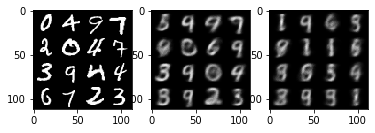

<Epoch:29/1000, Step:240/545>total_loss: 177.4003, kl_loss: 20.6482, recon_loss: 156.7521
<Epoch:30/1000, Step:195/545>total_loss: 171.4551, kl_loss: 19.8826, recon_loss: 151.5726
<Epoch:31/1000, Step:150/545>total_loss: 182.2678, kl_loss: 19.8291, recon_loss: 162.4387
<Epoch:32/1000, Step:105/545>total_loss: 178.4048, kl_loss: 21.0219, recon_loss: 157.3828
<Epoch:33/1000, Step:060/545>total_loss: 173.2056, kl_loss: 19.9212, recon_loss: 153.2844


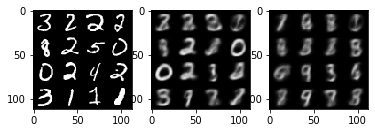

<Epoch:34/1000, Step:015/545>total_loss: 177.1003, kl_loss: 21.3491, recon_loss: 155.7511
<Epoch:34/1000, Step:515/545>total_loss: 173.0918, kl_loss: 21.5933, recon_loss: 151.4986
<Epoch:35/1000, Step:470/545>total_loss: 181.6421, kl_loss: 20.3397, recon_loss: 161.3024
<Epoch:36/1000, Step:425/545>total_loss: 181.8287, kl_loss: 20.5500, recon_loss: 161.2787
<Epoch:37/1000, Step:380/545>total_loss: 175.7133, kl_loss: 20.7431, recon_loss: 154.9701


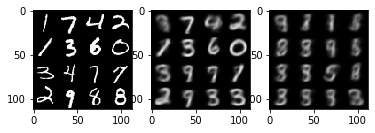

<Epoch:38/1000, Step:335/545>total_loss: 176.7737, kl_loss: 21.8025, recon_loss: 154.9712
<Epoch:39/1000, Step:290/545>total_loss: 176.0187, kl_loss: 20.7588, recon_loss: 155.2598
<Epoch:40/1000, Step:245/545>total_loss: 168.1371, kl_loss: 21.4701, recon_loss: 146.6670
<Epoch:41/1000, Step:200/545>total_loss: 169.9093, kl_loss: 20.7031, recon_loss: 149.2062
<Epoch:42/1000, Step:155/545>total_loss: 167.8717, kl_loss: 20.4332, recon_loss: 147.4385


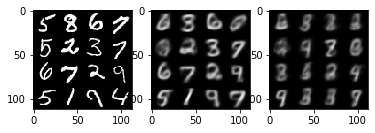

<Epoch:43/1000, Step:110/545>total_loss: 173.2129, kl_loss: 19.7836, recon_loss: 153.4293
<Epoch:44/1000, Step:065/545>total_loss: 170.2443, kl_loss: 19.0080, recon_loss: 151.2363
<Epoch:45/1000, Step:020/545>total_loss: 173.5595, kl_loss: 21.4548, recon_loss: 152.1046
<Epoch:45/1000, Step:520/545>total_loss: 166.8653, kl_loss: 20.8387, recon_loss: 146.0266
<Epoch:46/1000, Step:475/545>total_loss: 175.3578, kl_loss: 21.8698, recon_loss: 153.4880


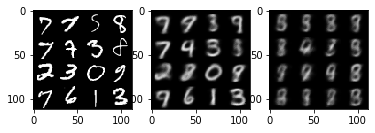

<Epoch:47/1000, Step:430/545>total_loss: 179.0275, kl_loss: 21.3011, recon_loss: 157.7264
<Epoch:48/1000, Step:385/545>total_loss: 171.8795, kl_loss: 22.2392, recon_loss: 149.6402
<Epoch:49/1000, Step:340/545>total_loss: 172.9015, kl_loss: 21.7249, recon_loss: 151.1767
<Epoch:50/1000, Step:295/545>total_loss: 166.9692, kl_loss: 20.6655, recon_loss: 146.3037
<Epoch:51/1000, Step:250/545>total_loss: 177.1366, kl_loss: 21.6148, recon_loss: 155.5219


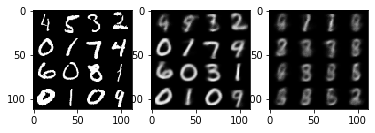

<Epoch:52/1000, Step:205/545>total_loss: 172.9198, kl_loss: 20.4216, recon_loss: 152.4982
<Epoch:53/1000, Step:160/545>total_loss: 185.0802, kl_loss: 22.2657, recon_loss: 162.8145
<Epoch:54/1000, Step:115/545>total_loss: 169.1051, kl_loss: 20.6963, recon_loss: 148.4088
<Epoch:55/1000, Step:070/545>total_loss: 179.1064, kl_loss: 21.3602, recon_loss: 157.7461
<Epoch:56/1000, Step:025/545>total_loss: 173.9542, kl_loss: 21.3911, recon_loss: 152.5631


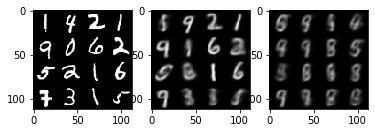

<Epoch:56/1000, Step:525/545>total_loss: 174.3554, kl_loss: 20.8849, recon_loss: 153.4705
<Epoch:57/1000, Step:480/545>total_loss: 167.1387, kl_loss: 22.0940, recon_loss: 145.0447
<Epoch:58/1000, Step:435/545>total_loss: 179.1682, kl_loss: 21.8387, recon_loss: 157.3295
<Epoch:59/1000, Step:390/545>total_loss: 168.5122, kl_loss: 22.2671, recon_loss: 146.2451
<Epoch:60/1000, Step:345/545>total_loss: 173.5266, kl_loss: 21.8438, recon_loss: 151.6828


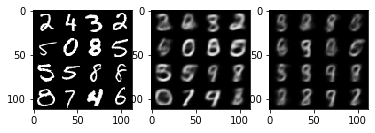

<Epoch:61/1000, Step:300/545>total_loss: 179.6521, kl_loss: 21.1440, recon_loss: 158.5082
<Epoch:62/1000, Step:255/545>total_loss: 172.9203, kl_loss: 21.7898, recon_loss: 151.1305
<Epoch:63/1000, Step:210/545>total_loss: 179.7297, kl_loss: 22.5859, recon_loss: 157.1437
<Epoch:64/1000, Step:165/545>total_loss: 170.7998, kl_loss: 22.8794, recon_loss: 147.9204
<Epoch:65/1000, Step:120/545>total_loss: 173.2672, kl_loss: 21.0014, recon_loss: 152.2658


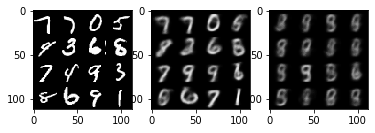

<Epoch:66/1000, Step:075/545>total_loss: 166.8770, kl_loss: 22.3169, recon_loss: 144.5602
<Epoch:67/1000, Step:030/545>total_loss: 168.5009, kl_loss: 21.2252, recon_loss: 147.2757
<Epoch:67/1000, Step:530/545>total_loss: 174.4057, kl_loss: 21.2677, recon_loss: 153.1380
<Epoch:68/1000, Step:485/545>total_loss: 176.8913, kl_loss: 23.1097, recon_loss: 153.7816
<Epoch:69/1000, Step:440/545>total_loss: 168.4309, kl_loss: 19.9285, recon_loss: 148.5024


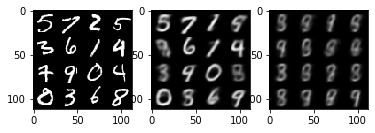

<Epoch:70/1000, Step:395/545>total_loss: 170.0773, kl_loss: 21.1729, recon_loss: 148.9044
<Epoch:71/1000, Step:350/545>total_loss: 170.7447, kl_loss: 22.1807, recon_loss: 148.5640
<Epoch:72/1000, Step:305/545>total_loss: 174.5568, kl_loss: 22.4404, recon_loss: 152.1164
<Epoch:73/1000, Step:260/545>total_loss: 176.8570, kl_loss: 22.2898, recon_loss: 154.5671
<Epoch:74/1000, Step:215/545>total_loss: 173.1340, kl_loss: 22.3617, recon_loss: 150.7722


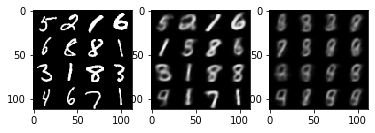

<Epoch:75/1000, Step:170/545>total_loss: 168.0262, kl_loss: 23.1008, recon_loss: 144.9254
<Epoch:76/1000, Step:125/545>total_loss: 173.7531, kl_loss: 21.2725, recon_loss: 152.4806
<Epoch:77/1000, Step:080/545>total_loss: 169.5410, kl_loss: 22.4393, recon_loss: 147.1016
<Epoch:78/1000, Step:035/545>total_loss: 171.1977, kl_loss: 23.0715, recon_loss: 148.1261
<Epoch:78/1000, Step:535/545>total_loss: 172.0060, kl_loss: 21.4553, recon_loss: 150.5506


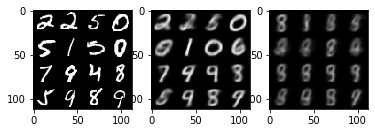

<Epoch:79/1000, Step:490/545>total_loss: 175.2605, kl_loss: 21.0286, recon_loss: 154.2319
<Epoch:80/1000, Step:445/545>total_loss: 167.5439, kl_loss: 21.4470, recon_loss: 146.0968
<Epoch:81/1000, Step:400/545>total_loss: 171.7226, kl_loss: 22.0261, recon_loss: 149.6965
<Epoch:82/1000, Step:355/545>total_loss: 174.5018, kl_loss: 21.8266, recon_loss: 152.6753
<Epoch:83/1000, Step:310/545>total_loss: 174.7368, kl_loss: 23.9905, recon_loss: 150.7463


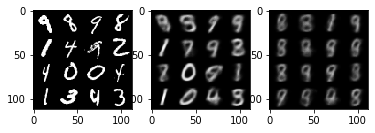

<Epoch:84/1000, Step:265/545>total_loss: 163.3717, kl_loss: 23.2122, recon_loss: 140.1594
<Epoch:85/1000, Step:220/545>total_loss: 166.9905, kl_loss: 21.4311, recon_loss: 145.5594
<Epoch:86/1000, Step:175/545>total_loss: 165.8618, kl_loss: 22.0531, recon_loss: 143.8088
<Epoch:87/1000, Step:130/545>total_loss: 175.4626, kl_loss: 21.6087, recon_loss: 153.8539
<Epoch:88/1000, Step:085/545>total_loss: 165.5607, kl_loss: 21.7453, recon_loss: 143.8154


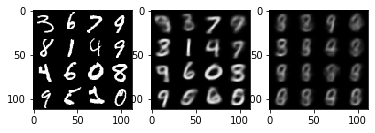

<Epoch:89/1000, Step:040/545>total_loss: 163.2071, kl_loss: 21.6296, recon_loss: 141.5775
<Epoch:89/1000, Step:540/545>total_loss: 173.6557, kl_loss: 22.6089, recon_loss: 151.0468
<Epoch:90/1000, Step:495/545>total_loss: 171.3403, kl_loss: 22.2446, recon_loss: 149.0957
<Epoch:91/1000, Step:450/545>total_loss: 159.5820, kl_loss: 23.5921, recon_loss: 135.9899
<Epoch:92/1000, Step:405/545>total_loss: 171.6702, kl_loss: 22.9786, recon_loss: 148.6916


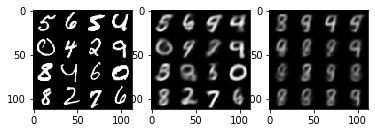

<Epoch:93/1000, Step:360/545>total_loss: 168.6754, kl_loss: 21.9301, recon_loss: 146.7453
<Epoch:94/1000, Step:315/545>total_loss: 167.6397, kl_loss: 22.8776, recon_loss: 144.7621
<Epoch:95/1000, Step:270/545>total_loss: 174.1922, kl_loss: 23.7896, recon_loss: 150.4025
<Epoch:96/1000, Step:225/545>total_loss: 169.7241, kl_loss: 21.8902, recon_loss: 147.8339
<Epoch:97/1000, Step:180/545>total_loss: 174.3091, kl_loss: 21.7153, recon_loss: 152.5938


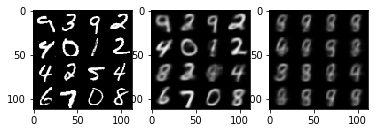

<Epoch:98/1000, Step:135/545>total_loss: 170.4606, kl_loss: 22.9382, recon_loss: 147.5225
<Epoch:99/1000, Step:090/545>total_loss: 171.1902, kl_loss: 23.2803, recon_loss: 147.9099
<Epoch:100/1000, Step:045/545>total_loss: 163.2762, kl_loss: 21.8785, recon_loss: 141.3976
<Epoch:100/1000, Step:545/545>total_loss: 168.8511, kl_loss: 22.6457, recon_loss: 146.2054
<Epoch:101/1000, Step:500/545>total_loss: 172.3777, kl_loss: 23.2662, recon_loss: 149.1115


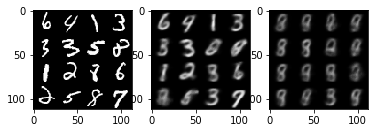

<Epoch:102/1000, Step:455/545>total_loss: 169.2017, kl_loss: 21.7001, recon_loss: 147.5015
<Epoch:103/1000, Step:410/545>total_loss: 171.1222, kl_loss: 21.5306, recon_loss: 149.5916
<Epoch:104/1000, Step:365/545>total_loss: 168.6362, kl_loss: 23.3565, recon_loss: 145.2797
<Epoch:105/1000, Step:320/545>total_loss: 162.0747, kl_loss: 21.8836, recon_loss: 140.1911
<Epoch:106/1000, Step:275/545>total_loss: 166.2326, kl_loss: 22.2703, recon_loss: 143.9623


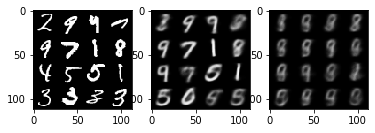

<Epoch:107/1000, Step:230/545>total_loss: 167.5139, kl_loss: 22.6548, recon_loss: 144.8591
<Epoch:108/1000, Step:185/545>total_loss: 178.1077, kl_loss: 23.8392, recon_loss: 154.2686
<Epoch:109/1000, Step:140/545>total_loss: 164.6220, kl_loss: 24.8982, recon_loss: 139.7238
<Epoch:110/1000, Step:095/545>total_loss: 169.4918, kl_loss: 22.4278, recon_loss: 147.0641
<Epoch:111/1000, Step:050/545>total_loss: 167.6975, kl_loss: 23.0975, recon_loss: 144.6000


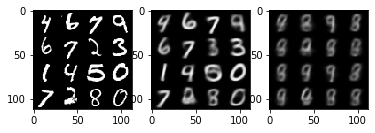

<Epoch:112/1000, Step:005/545>total_loss: 162.4789, kl_loss: 21.0865, recon_loss: 141.3924
<Epoch:112/1000, Step:505/545>total_loss: 167.4583, kl_loss: 22.8350, recon_loss: 144.6234
<Epoch:113/1000, Step:460/545>total_loss: 163.2250, kl_loss: 22.7418, recon_loss: 140.4832
<Epoch:114/1000, Step:415/545>total_loss: 168.3987, kl_loss: 23.5108, recon_loss: 144.8880
<Epoch:115/1000, Step:370/545>total_loss: 172.9481, kl_loss: 23.7703, recon_loss: 149.1777


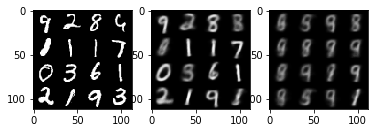

<Epoch:116/1000, Step:325/545>total_loss: 170.0527, kl_loss: 22.5863, recon_loss: 147.4663
<Epoch:117/1000, Step:280/545>total_loss: 172.4400, kl_loss: 21.6438, recon_loss: 150.7962
<Epoch:118/1000, Step:235/545>total_loss: 169.5943, kl_loss: 23.6823, recon_loss: 145.9120
<Epoch:119/1000, Step:190/545>total_loss: 168.5697, kl_loss: 23.5391, recon_loss: 145.0306
<Epoch:120/1000, Step:145/545>total_loss: 171.6872, kl_loss: 23.7397, recon_loss: 147.9475


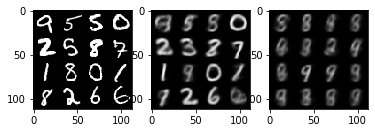

<Epoch:121/1000, Step:100/545>total_loss: 165.8761, kl_loss: 23.4410, recon_loss: 142.4352
<Epoch:122/1000, Step:055/545>total_loss: 175.1064, kl_loss: 23.9660, recon_loss: 151.1404
<Epoch:123/1000, Step:010/545>total_loss: 170.9411, kl_loss: 22.0417, recon_loss: 148.8994
<Epoch:123/1000, Step:510/545>total_loss: 170.0055, kl_loss: 21.1957, recon_loss: 148.8098
<Epoch:124/1000, Step:465/545>total_loss: 170.3340, kl_loss: 22.6095, recon_loss: 147.7245


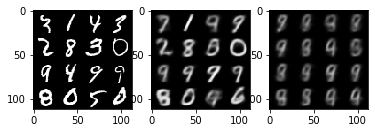

<Epoch:125/1000, Step:420/545>total_loss: 165.7949, kl_loss: 22.5249, recon_loss: 143.2700
<Epoch:126/1000, Step:375/545>total_loss: 172.3569, kl_loss: 23.9656, recon_loss: 148.3912
<Epoch:127/1000, Step:330/545>total_loss: 173.2794, kl_loss: 23.6704, recon_loss: 149.6090
<Epoch:128/1000, Step:285/545>total_loss: 175.8271, kl_loss: 22.9950, recon_loss: 152.8320
<Epoch:129/1000, Step:240/545>total_loss: 169.3313, kl_loss: 22.3501, recon_loss: 146.9812


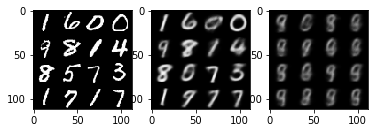

<Epoch:130/1000, Step:195/545>total_loss: 170.3512, kl_loss: 20.9472, recon_loss: 149.4040
<Epoch:131/1000, Step:150/545>total_loss: 169.3869, kl_loss: 23.2636, recon_loss: 146.1233
<Epoch:132/1000, Step:105/545>total_loss: 170.3756, kl_loss: 22.5506, recon_loss: 147.8250
<Epoch:133/1000, Step:060/545>total_loss: 173.0674, kl_loss: 21.6930, recon_loss: 151.3744
<Epoch:134/1000, Step:015/545>total_loss: 172.9777, kl_loss: 23.8112, recon_loss: 149.1665


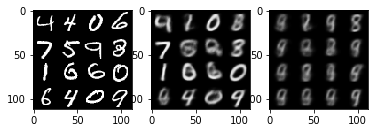

<Epoch:134/1000, Step:515/545>total_loss: 169.2024, kl_loss: 21.8705, recon_loss: 147.3320
<Epoch:135/1000, Step:470/545>total_loss: 170.3761, kl_loss: 23.1779, recon_loss: 147.1982
<Epoch:136/1000, Step:425/545>total_loss: 161.2264, kl_loss: 22.3473, recon_loss: 138.8791
<Epoch:137/1000, Step:380/545>total_loss: 170.2591, kl_loss: 24.6852, recon_loss: 145.5739
<Epoch:138/1000, Step:335/545>total_loss: 165.9484, kl_loss: 23.9725, recon_loss: 141.9759


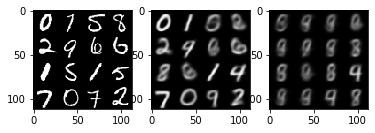

<Epoch:139/1000, Step:290/545>total_loss: 166.2301, kl_loss: 24.4837, recon_loss: 141.7464
<Epoch:140/1000, Step:245/545>total_loss: 162.9160, kl_loss: 23.9974, recon_loss: 138.9186
<Epoch:141/1000, Step:200/545>total_loss: 163.7455, kl_loss: 21.8239, recon_loss: 141.9216
<Epoch:142/1000, Step:155/545>total_loss: 172.2050, kl_loss: 24.6098, recon_loss: 147.5952
<Epoch:143/1000, Step:110/545>total_loss: 173.3848, kl_loss: 21.7701, recon_loss: 151.6146


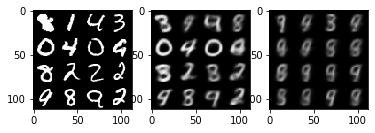

<Epoch:144/1000, Step:065/545>total_loss: 166.3870, kl_loss: 23.9424, recon_loss: 142.4446
<Epoch:145/1000, Step:020/545>total_loss: 167.4552, kl_loss: 23.8525, recon_loss: 143.6027
<Epoch:145/1000, Step:520/545>total_loss: 169.5523, kl_loss: 23.4793, recon_loss: 146.0730
<Epoch:146/1000, Step:475/545>total_loss: 165.4376, kl_loss: 23.4359, recon_loss: 142.0017
<Epoch:147/1000, Step:430/545>total_loss: 162.3936, kl_loss: 22.0804, recon_loss: 140.3132


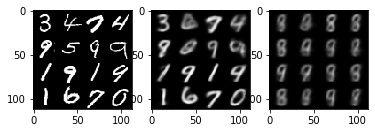

<Epoch:148/1000, Step:385/545>total_loss: 170.5044, kl_loss: 23.3941, recon_loss: 147.1103
<Epoch:149/1000, Step:340/545>total_loss: 165.0701, kl_loss: 22.8406, recon_loss: 142.2295
<Epoch:150/1000, Step:295/545>total_loss: 175.2506, kl_loss: 23.6211, recon_loss: 151.6295
<Epoch:151/1000, Step:250/545>total_loss: 169.8084, kl_loss: 24.4375, recon_loss: 145.3709
<Epoch:152/1000, Step:205/545>total_loss: 173.1255, kl_loss: 22.1263, recon_loss: 150.9993


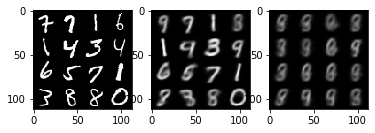

<Epoch:153/1000, Step:160/545>total_loss: 167.0957, kl_loss: 21.5998, recon_loss: 145.4959
<Epoch:154/1000, Step:115/545>total_loss: 170.8979, kl_loss: 23.2940, recon_loss: 147.6040
<Epoch:155/1000, Step:070/545>total_loss: 172.3389, kl_loss: 22.5656, recon_loss: 149.7733
<Epoch:156/1000, Step:025/545>total_loss: 168.9371, kl_loss: 22.2963, recon_loss: 146.6408
<Epoch:156/1000, Step:525/545>total_loss: 162.2951, kl_loss: 23.6563, recon_loss: 138.6388


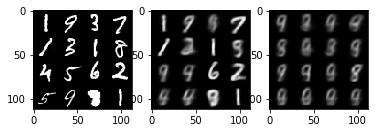

<Epoch:157/1000, Step:480/545>total_loss: 165.8058, kl_loss: 22.6735, recon_loss: 143.1323
<Epoch:158/1000, Step:435/545>total_loss: 165.8645, kl_loss: 23.0970, recon_loss: 142.7675
<Epoch:159/1000, Step:390/545>total_loss: 167.1851, kl_loss: 23.3499, recon_loss: 143.8351
<Epoch:160/1000, Step:345/545>total_loss: 165.4056, kl_loss: 22.4547, recon_loss: 142.9508
<Epoch:161/1000, Step:300/545>total_loss: 169.3923, kl_loss: 23.7842, recon_loss: 145.6081


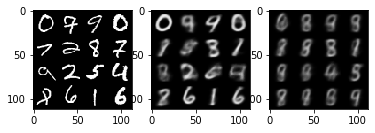

<Epoch:162/1000, Step:255/545>total_loss: 176.4117, kl_loss: 24.0189, recon_loss: 152.3928
<Epoch:163/1000, Step:210/545>total_loss: 167.2842, kl_loss: 23.3264, recon_loss: 143.9578
<Epoch:164/1000, Step:165/545>total_loss: 167.0567, kl_loss: 22.4413, recon_loss: 144.6154
<Epoch:165/1000, Step:120/545>total_loss: 167.0040, kl_loss: 22.3360, recon_loss: 144.6680
<Epoch:166/1000, Step:075/545>total_loss: 173.8996, kl_loss: 23.2233, recon_loss: 150.6764


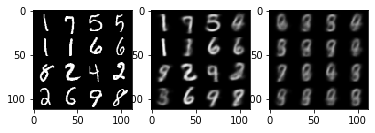

<Epoch:167/1000, Step:030/545>total_loss: 168.9379, kl_loss: 21.8452, recon_loss: 147.0927
<Epoch:167/1000, Step:530/545>total_loss: 167.5870, kl_loss: 23.5789, recon_loss: 144.0081
<Epoch:168/1000, Step:485/545>total_loss: 170.9994, kl_loss: 25.2934, recon_loss: 145.7061
<Epoch:169/1000, Step:440/545>total_loss: 167.1187, kl_loss: 23.7574, recon_loss: 143.3613
<Epoch:170/1000, Step:395/545>total_loss: 171.0311, kl_loss: 24.0879, recon_loss: 146.9433


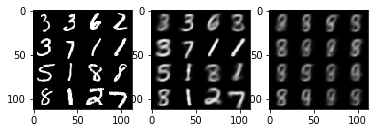

<Epoch:171/1000, Step:350/545>total_loss: 168.7815, kl_loss: 22.0251, recon_loss: 146.7564
<Epoch:172/1000, Step:305/545>total_loss: 167.5125, kl_loss: 22.9532, recon_loss: 144.5594
<Epoch:173/1000, Step:260/545>total_loss: 174.6369, kl_loss: 23.5105, recon_loss: 151.1264
<Epoch:174/1000, Step:215/545>total_loss: 166.8021, kl_loss: 25.0894, recon_loss: 141.7126
<Epoch:175/1000, Step:170/545>total_loss: 165.8605, kl_loss: 23.9727, recon_loss: 141.8878


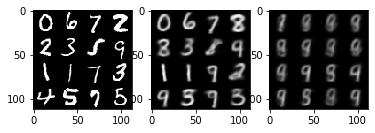

<Epoch:176/1000, Step:125/545>total_loss: 175.0556, kl_loss: 24.5993, recon_loss: 150.4562
<Epoch:177/1000, Step:080/545>total_loss: 169.2066, kl_loss: 22.4127, recon_loss: 146.7939
<Epoch:178/1000, Step:035/545>total_loss: 169.8203, kl_loss: 24.2068, recon_loss: 145.6136
<Epoch:178/1000, Step:535/545>total_loss: 174.2686, kl_loss: 22.2805, recon_loss: 151.9881
<Epoch:179/1000, Step:490/545>total_loss: 171.1254, kl_loss: 23.8120, recon_loss: 147.3134


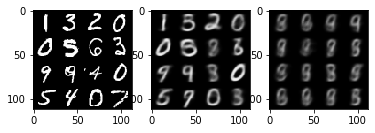

<Epoch:180/1000, Step:445/545>total_loss: 172.0027, kl_loss: 24.1313, recon_loss: 147.8714
<Epoch:181/1000, Step:400/545>total_loss: 170.7375, kl_loss: 25.0201, recon_loss: 145.7174
<Epoch:182/1000, Step:355/545>total_loss: 172.0520, kl_loss: 23.4860, recon_loss: 148.5660
<Epoch:183/1000, Step:310/545>total_loss: 172.1903, kl_loss: 22.3068, recon_loss: 149.8835
<Epoch:184/1000, Step:265/545>total_loss: 167.0120, kl_loss: 23.7030, recon_loss: 143.3090


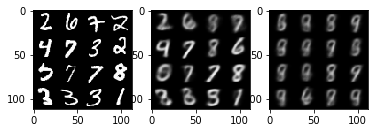

<Epoch:185/1000, Step:220/545>total_loss: 162.7705, kl_loss: 21.6198, recon_loss: 141.1507
<Epoch:186/1000, Step:175/545>total_loss: 175.7247, kl_loss: 25.7972, recon_loss: 149.9275
<Epoch:187/1000, Step:130/545>total_loss: 164.2071, kl_loss: 22.4703, recon_loss: 141.7369
<Epoch:188/1000, Step:085/545>total_loss: 163.6827, kl_loss: 25.3040, recon_loss: 138.3787
<Epoch:189/1000, Step:040/545>total_loss: 168.7281, kl_loss: 23.4323, recon_loss: 145.2958


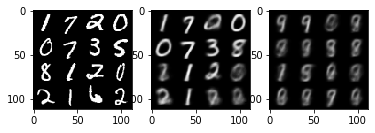

<Epoch:189/1000, Step:540/545>total_loss: 169.9781, kl_loss: 23.7104, recon_loss: 146.2677
<Epoch:190/1000, Step:495/545>total_loss: 162.7788, kl_loss: 22.7032, recon_loss: 140.0756
<Epoch:191/1000, Step:450/545>total_loss: 172.6633, kl_loss: 24.8616, recon_loss: 147.8018
<Epoch:192/1000, Step:405/545>total_loss: 162.5921, kl_loss: 22.0563, recon_loss: 140.5358
<Epoch:193/1000, Step:360/545>total_loss: 168.0885, kl_loss: 23.7884, recon_loss: 144.3000


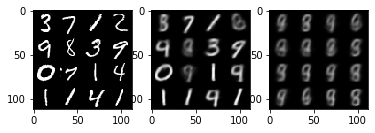

<Epoch:194/1000, Step:315/545>total_loss: 171.0433, kl_loss: 23.5097, recon_loss: 147.5336
<Epoch:195/1000, Step:270/545>total_loss: 169.9128, kl_loss: 25.0325, recon_loss: 144.8803
<Epoch:196/1000, Step:225/545>total_loss: 161.5472, kl_loss: 23.8265, recon_loss: 137.7207
<Epoch:197/1000, Step:180/545>total_loss: 170.1622, kl_loss: 24.1759, recon_loss: 145.9863
<Epoch:198/1000, Step:135/545>total_loss: 168.6589, kl_loss: 24.0546, recon_loss: 144.6043


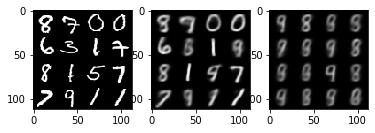

<Epoch:199/1000, Step:090/545>total_loss: 174.9334, kl_loss: 24.9387, recon_loss: 149.9948
<Epoch:200/1000, Step:045/545>total_loss: 167.1067, kl_loss: 24.1793, recon_loss: 142.9274
<Epoch:200/1000, Step:545/545>total_loss: 167.3843, kl_loss: 23.6866, recon_loss: 143.6977
<Epoch:201/1000, Step:500/545>total_loss: 166.1533, kl_loss: 24.6546, recon_loss: 141.4987
<Epoch:202/1000, Step:455/545>total_loss: 168.9099, kl_loss: 24.0733, recon_loss: 144.8366


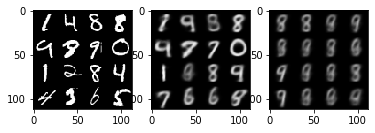

<Epoch:203/1000, Step:410/545>total_loss: 169.8712, kl_loss: 24.1840, recon_loss: 145.6872
<Epoch:204/1000, Step:365/545>total_loss: 165.9263, kl_loss: 21.5584, recon_loss: 144.3679
<Epoch:205/1000, Step:320/545>total_loss: 168.6550, kl_loss: 22.4171, recon_loss: 146.2380
<Epoch:206/1000, Step:275/545>total_loss: 166.7808, kl_loss: 22.7350, recon_loss: 144.0459
<Epoch:207/1000, Step:230/545>total_loss: 168.5114, kl_loss: 25.2977, recon_loss: 143.2137


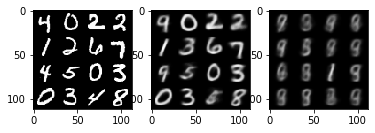

<Epoch:208/1000, Step:185/545>total_loss: 178.9921, kl_loss: 24.8898, recon_loss: 154.1023
<Epoch:209/1000, Step:140/545>total_loss: 158.2440, kl_loss: 23.3084, recon_loss: 134.9357
<Epoch:210/1000, Step:095/545>total_loss: 167.5446, kl_loss: 24.5027, recon_loss: 143.0419
<Epoch:211/1000, Step:050/545>total_loss: 169.8908, kl_loss: 22.6094, recon_loss: 147.2813
<Epoch:212/1000, Step:005/545>total_loss: 169.4912, kl_loss: 23.0959, recon_loss: 146.3953


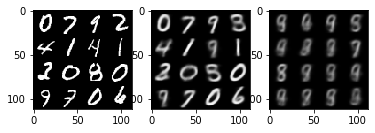

<Epoch:212/1000, Step:505/545>total_loss: 163.4098, kl_loss: 22.5396, recon_loss: 140.8702
<Epoch:213/1000, Step:460/545>total_loss: 169.9369, kl_loss: 22.8576, recon_loss: 147.0793
<Epoch:214/1000, Step:415/545>total_loss: 175.3672, kl_loss: 25.8486, recon_loss: 149.5185
<Epoch:215/1000, Step:370/545>total_loss: 170.4131, kl_loss: 23.6133, recon_loss: 146.7998
<Epoch:216/1000, Step:325/545>total_loss: 166.8666, kl_loss: 22.6624, recon_loss: 144.2042


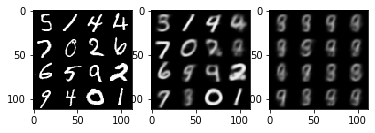

<Epoch:217/1000, Step:280/545>total_loss: 171.3728, kl_loss: 24.3120, recon_loss: 147.0608
<Epoch:218/1000, Step:235/545>total_loss: 168.9481, kl_loss: 22.8095, recon_loss: 146.1386
<Epoch:219/1000, Step:190/545>total_loss: 173.6516, kl_loss: 23.7043, recon_loss: 149.9473
<Epoch:220/1000, Step:145/545>total_loss: 164.3868, kl_loss: 23.4132, recon_loss: 140.9736
<Epoch:221/1000, Step:100/545>total_loss: 171.9229, kl_loss: 23.4459, recon_loss: 148.4770


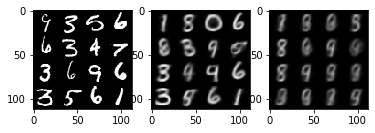

<Epoch:222/1000, Step:055/545>total_loss: 166.5275, kl_loss: 22.4169, recon_loss: 144.1105
<Epoch:223/1000, Step:010/545>total_loss: 168.3172, kl_loss: 23.5884, recon_loss: 144.7289
<Epoch:223/1000, Step:510/545>total_loss: 171.4680, kl_loss: 22.8472, recon_loss: 148.6208
<Epoch:224/1000, Step:465/545>total_loss: 166.4495, kl_loss: 24.4400, recon_loss: 142.0095
<Epoch:225/1000, Step:420/545>total_loss: 167.0870, kl_loss: 22.6678, recon_loss: 144.4192


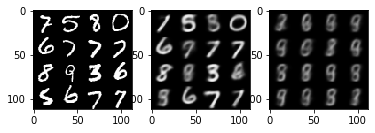

<Epoch:226/1000, Step:375/545>total_loss: 166.2977, kl_loss: 26.2413, recon_loss: 140.0564
<Epoch:227/1000, Step:330/545>total_loss: 171.8878, kl_loss: 24.0845, recon_loss: 147.8033
<Epoch:228/1000, Step:285/545>total_loss: 169.1018, kl_loss: 24.8940, recon_loss: 144.2078
<Epoch:229/1000, Step:240/545>total_loss: 161.7072, kl_loss: 22.6236, recon_loss: 139.0835
<Epoch:230/1000, Step:195/545>total_loss: 165.0152, kl_loss: 23.6179, recon_loss: 141.3973


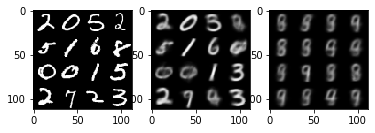

<Epoch:231/1000, Step:150/545>total_loss: 170.1452, kl_loss: 24.0954, recon_loss: 146.0499
<Epoch:232/1000, Step:105/545>total_loss: 165.8543, kl_loss: 22.9003, recon_loss: 142.9540
<Epoch:233/1000, Step:060/545>total_loss: 169.7080, kl_loss: 23.2583, recon_loss: 146.4496
<Epoch:234/1000, Step:015/545>total_loss: 166.9684, kl_loss: 23.9343, recon_loss: 143.0341
<Epoch:234/1000, Step:515/545>total_loss: 173.8369, kl_loss: 23.5137, recon_loss: 150.3232


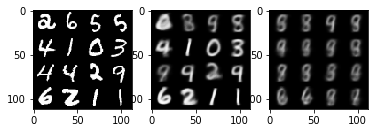

<Epoch:235/1000, Step:470/545>total_loss: 166.9177, kl_loss: 23.5601, recon_loss: 143.3576
<Epoch:236/1000, Step:425/545>total_loss: 171.6501, kl_loss: 24.7034, recon_loss: 146.9467
<Epoch:237/1000, Step:380/545>total_loss: 170.9860, kl_loss: 23.7219, recon_loss: 147.2641
<Epoch:238/1000, Step:335/545>total_loss: 170.6347, kl_loss: 24.4567, recon_loss: 146.1780
<Epoch:239/1000, Step:290/545>total_loss: 167.0867, kl_loss: 23.1393, recon_loss: 143.9474


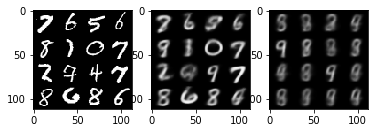

<Epoch:240/1000, Step:245/545>total_loss: 161.0421, kl_loss: 24.8736, recon_loss: 136.1685
<Epoch:241/1000, Step:200/545>total_loss: 168.7043, kl_loss: 23.8811, recon_loss: 144.8232
<Epoch:242/1000, Step:155/545>total_loss: 169.8221, kl_loss: 24.7666, recon_loss: 145.0555
<Epoch:243/1000, Step:110/545>total_loss: 168.8447, kl_loss: 24.1520, recon_loss: 144.6926
<Epoch:244/1000, Step:065/545>total_loss: 169.2708, kl_loss: 24.4646, recon_loss: 144.8063


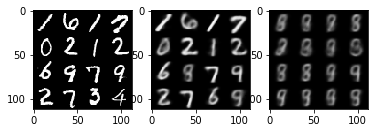

<Epoch:245/1000, Step:020/545>total_loss: 171.2488, kl_loss: 24.3908, recon_loss: 146.8580
<Epoch:245/1000, Step:520/545>total_loss: 170.9863, kl_loss: 24.3813, recon_loss: 146.6050
<Epoch:246/1000, Step:475/545>total_loss: 165.2285, kl_loss: 24.8190, recon_loss: 140.4095
<Epoch:247/1000, Step:430/545>total_loss: 163.5711, kl_loss: 24.6277, recon_loss: 138.9434
<Epoch:248/1000, Step:385/545>total_loss: 168.9300, kl_loss: 25.2242, recon_loss: 143.7058


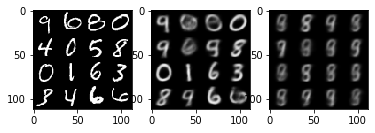

<Epoch:249/1000, Step:340/545>total_loss: 160.5282, kl_loss: 23.3351, recon_loss: 137.1931
<Epoch:250/1000, Step:295/545>total_loss: 166.0012, kl_loss: 22.7703, recon_loss: 143.2309
<Epoch:251/1000, Step:250/545>total_loss: 171.9645, kl_loss: 24.2794, recon_loss: 147.6851
<Epoch:252/1000, Step:205/545>total_loss: 165.7390, kl_loss: 23.0257, recon_loss: 142.7133
<Epoch:253/1000, Step:160/545>total_loss: 174.7603, kl_loss: 25.0342, recon_loss: 149.7261


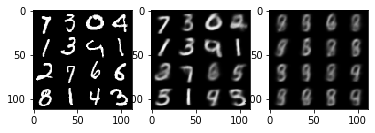

<Epoch:254/1000, Step:115/545>total_loss: 164.9889, kl_loss: 26.0074, recon_loss: 138.9815
<Epoch:255/1000, Step:070/545>total_loss: 163.8979, kl_loss: 24.0989, recon_loss: 139.7990
<Epoch:256/1000, Step:025/545>total_loss: 168.0080, kl_loss: 23.6450, recon_loss: 144.3630
<Epoch:256/1000, Step:525/545>total_loss: 169.2795, kl_loss: 23.2104, recon_loss: 146.0691
<Epoch:257/1000, Step:480/545>total_loss: 167.9504, kl_loss: 23.9188, recon_loss: 144.0316


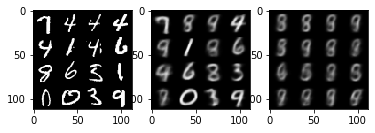

<Epoch:258/1000, Step:435/545>total_loss: 170.0326, kl_loss: 23.5289, recon_loss: 146.5037
<Epoch:259/1000, Step:390/545>total_loss: 166.3829, kl_loss: 25.1942, recon_loss: 141.1887
<Epoch:260/1000, Step:345/545>total_loss: 172.8858, kl_loss: 25.4128, recon_loss: 147.4731
<Epoch:261/1000, Step:300/545>total_loss: 167.7739, kl_loss: 25.2645, recon_loss: 142.5094
<Epoch:262/1000, Step:255/545>total_loss: 168.5820, kl_loss: 23.8812, recon_loss: 144.7008


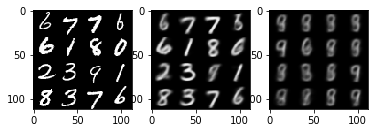

<Epoch:263/1000, Step:210/545>total_loss: 171.7800, kl_loss: 25.6800, recon_loss: 146.1000
<Epoch:264/1000, Step:165/545>total_loss: 161.6396, kl_loss: 25.0497, recon_loss: 136.5899
<Epoch:265/1000, Step:120/545>total_loss: 171.1722, kl_loss: 23.9401, recon_loss: 147.2321
<Epoch:266/1000, Step:075/545>total_loss: 170.3208, kl_loss: 23.7035, recon_loss: 146.6174
<Epoch:267/1000, Step:030/545>total_loss: 169.4998, kl_loss: 23.5113, recon_loss: 145.9885


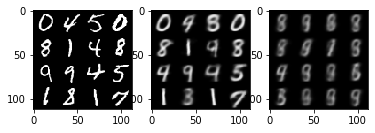

<Epoch:267/1000, Step:530/545>total_loss: 171.2629, kl_loss: 24.9740, recon_loss: 146.2888
<Epoch:268/1000, Step:485/545>total_loss: 175.4015, kl_loss: 24.6210, recon_loss: 150.7805
<Epoch:269/1000, Step:440/545>total_loss: 167.0054, kl_loss: 22.6100, recon_loss: 144.3954
<Epoch:270/1000, Step:395/545>total_loss: 168.2575, kl_loss: 23.3202, recon_loss: 144.9372
<Epoch:271/1000, Step:350/545>total_loss: 156.5412, kl_loss: 24.1693, recon_loss: 132.3719


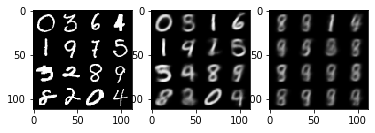

<Epoch:272/1000, Step:305/545>total_loss: 163.0186, kl_loss: 22.9011, recon_loss: 140.1176
<Epoch:273/1000, Step:260/545>total_loss: 169.7589, kl_loss: 24.1894, recon_loss: 145.5695
<Epoch:274/1000, Step:215/545>total_loss: 165.1061, kl_loss: 23.8900, recon_loss: 141.2161
<Epoch:275/1000, Step:170/545>total_loss: 166.0471, kl_loss: 23.8351, recon_loss: 142.2121
<Epoch:276/1000, Step:125/545>total_loss: 167.4458, kl_loss: 22.9989, recon_loss: 144.4469


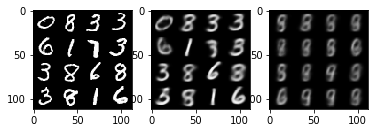

<Epoch:277/1000, Step:080/545>total_loss: 167.4646, kl_loss: 25.3091, recon_loss: 142.1555
<Epoch:278/1000, Step:035/545>total_loss: 162.6888, kl_loss: 23.5169, recon_loss: 139.1719
<Epoch:278/1000, Step:535/545>total_loss: 171.6780, kl_loss: 25.3798, recon_loss: 146.2982
<Epoch:279/1000, Step:490/545>total_loss: 164.6919, kl_loss: 23.5683, recon_loss: 141.1236
<Epoch:280/1000, Step:445/545>total_loss: 168.6396, kl_loss: 24.5095, recon_loss: 144.1301


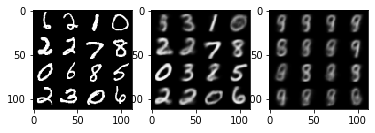

<Epoch:281/1000, Step:400/545>total_loss: 161.7424, kl_loss: 22.3550, recon_loss: 139.3874
<Epoch:282/1000, Step:355/545>total_loss: 159.6341, kl_loss: 24.3561, recon_loss: 135.2780
<Epoch:283/1000, Step:310/545>total_loss: 172.5665, kl_loss: 23.6041, recon_loss: 148.9624
<Epoch:284/1000, Step:265/545>total_loss: 166.7249, kl_loss: 24.9147, recon_loss: 141.8102
<Epoch:285/1000, Step:220/545>total_loss: 170.5955, kl_loss: 24.1408, recon_loss: 146.4547


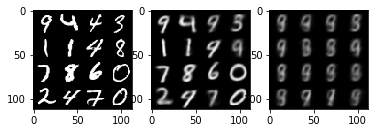

<Epoch:286/1000, Step:175/545>total_loss: 169.1903, kl_loss: 23.2016, recon_loss: 145.9888
<Epoch:287/1000, Step:130/545>total_loss: 167.6210, kl_loss: 23.5931, recon_loss: 144.0279
<Epoch:288/1000, Step:085/545>total_loss: 166.8043, kl_loss: 23.6925, recon_loss: 143.1118
<Epoch:289/1000, Step:040/545>total_loss: 169.5651, kl_loss: 25.6002, recon_loss: 143.9649
<Epoch:289/1000, Step:540/545>total_loss: 169.1774, kl_loss: 22.6480, recon_loss: 146.5294


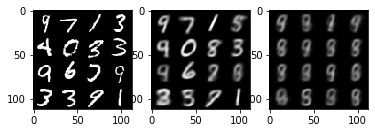

<Epoch:290/1000, Step:495/545>total_loss: 167.6547, kl_loss: 23.1243, recon_loss: 144.5304
<Epoch:291/1000, Step:450/545>total_loss: 169.5482, kl_loss: 23.6457, recon_loss: 145.9025
<Epoch:292/1000, Step:405/545>total_loss: 169.8129, kl_loss: 24.8054, recon_loss: 145.0075
<Epoch:293/1000, Step:360/545>total_loss: 165.4175, kl_loss: 25.1573, recon_loss: 140.2602
<Epoch:294/1000, Step:315/545>total_loss: 170.4127, kl_loss: 23.9331, recon_loss: 146.4797


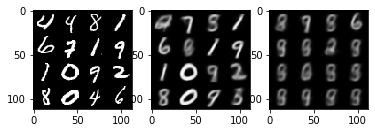

<Epoch:295/1000, Step:270/545>total_loss: 164.9881, kl_loss: 23.6535, recon_loss: 141.3346
<Epoch:296/1000, Step:225/545>total_loss: 176.6918, kl_loss: 24.7526, recon_loss: 151.9391
<Epoch:297/1000, Step:180/545>total_loss: 168.3900, kl_loss: 23.4104, recon_loss: 144.9796
<Epoch:298/1000, Step:135/545>total_loss: 173.3432, kl_loss: 23.7373, recon_loss: 149.6059
<Epoch:299/1000, Step:090/545>total_loss: 166.5435, kl_loss: 23.5964, recon_loss: 142.9470


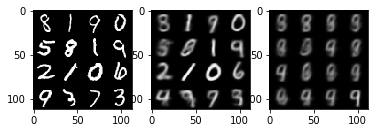

<Epoch:300/1000, Step:045/545>total_loss: 177.2496, kl_loss: 23.6961, recon_loss: 153.5535
<Epoch:300/1000, Step:545/545>total_loss: 169.5828, kl_loss: 22.8541, recon_loss: 146.7287
<Epoch:301/1000, Step:500/545>total_loss: 166.2848, kl_loss: 23.1879, recon_loss: 143.0969
<Epoch:302/1000, Step:455/545>total_loss: 168.8531, kl_loss: 23.3643, recon_loss: 145.4888
<Epoch:303/1000, Step:410/545>total_loss: 167.3952, kl_loss: 24.9471, recon_loss: 142.4480


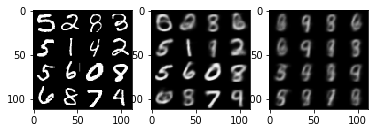

<Epoch:304/1000, Step:365/545>total_loss: 169.0486, kl_loss: 25.0120, recon_loss: 144.0367
<Epoch:305/1000, Step:320/545>total_loss: 168.5227, kl_loss: 23.4661, recon_loss: 145.0567
<Epoch:306/1000, Step:275/545>total_loss: 167.2542, kl_loss: 25.0826, recon_loss: 142.1716
<Epoch:307/1000, Step:230/545>total_loss: 167.8768, kl_loss: 23.8186, recon_loss: 144.0583
<Epoch:308/1000, Step:185/545>total_loss: 166.8205, kl_loss: 23.4689, recon_loss: 143.3517


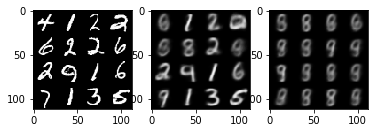

<Epoch:309/1000, Step:140/545>total_loss: 163.3452, kl_loss: 23.1224, recon_loss: 140.2229
<Epoch:310/1000, Step:095/545>total_loss: 172.0938, kl_loss: 23.3581, recon_loss: 148.7357
<Epoch:311/1000, Step:050/545>total_loss: 168.8381, kl_loss: 24.6229, recon_loss: 144.2153
<Epoch:312/1000, Step:005/545>total_loss: 164.8582, kl_loss: 25.4601, recon_loss: 139.3981
<Epoch:312/1000, Step:505/545>total_loss: 173.4847, kl_loss: 26.5025, recon_loss: 146.9822


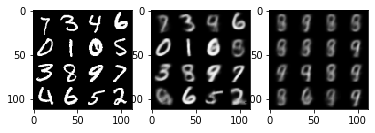

<Epoch:313/1000, Step:460/545>total_loss: 158.1620, kl_loss: 24.0218, recon_loss: 134.1402
<Epoch:314/1000, Step:415/545>total_loss: 170.3131, kl_loss: 24.9149, recon_loss: 145.3982
<Epoch:315/1000, Step:370/545>total_loss: 165.2608, kl_loss: 23.6560, recon_loss: 141.6048
<Epoch:316/1000, Step:325/545>total_loss: 162.1826, kl_loss: 22.9303, recon_loss: 139.2523
<Epoch:317/1000, Step:280/545>total_loss: 165.4995, kl_loss: 24.5705, recon_loss: 140.9289


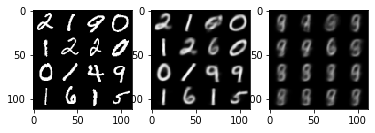

<Epoch:318/1000, Step:235/545>total_loss: 170.2546, kl_loss: 23.5673, recon_loss: 146.6873
<Epoch:319/1000, Step:190/545>total_loss: 170.8995, kl_loss: 25.0469, recon_loss: 145.8526
<Epoch:320/1000, Step:145/545>total_loss: 164.7026, kl_loss: 23.1727, recon_loss: 141.5299
<Epoch:321/1000, Step:100/545>total_loss: 165.9273, kl_loss: 23.2385, recon_loss: 142.6889
<Epoch:322/1000, Step:055/545>total_loss: 162.4286, kl_loss: 24.5781, recon_loss: 137.8506


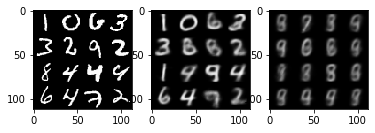

<Epoch:323/1000, Step:010/545>total_loss: 163.1726, kl_loss: 23.9624, recon_loss: 139.2102
<Epoch:323/1000, Step:510/545>total_loss: 167.3259, kl_loss: 25.7286, recon_loss: 141.5972
<Epoch:324/1000, Step:465/545>total_loss: 161.4256, kl_loss: 23.2463, recon_loss: 138.1793
<Epoch:325/1000, Step:420/545>total_loss: 172.9854, kl_loss: 25.2853, recon_loss: 147.7002
<Epoch:326/1000, Step:375/545>total_loss: 169.9390, kl_loss: 23.6649, recon_loss: 146.2741


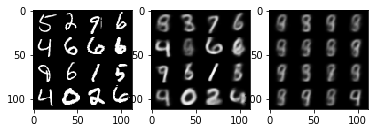

<Epoch:327/1000, Step:330/545>total_loss: 166.6699, kl_loss: 23.6096, recon_loss: 143.0603
<Epoch:328/1000, Step:285/545>total_loss: 169.4054, kl_loss: 25.2258, recon_loss: 144.1797
<Epoch:329/1000, Step:240/545>total_loss: 167.5325, kl_loss: 24.3013, recon_loss: 143.2312
<Epoch:330/1000, Step:195/545>total_loss: 165.4877, kl_loss: 24.7010, recon_loss: 140.7867
<Epoch:331/1000, Step:150/545>total_loss: 165.2255, kl_loss: 24.3855, recon_loss: 140.8400


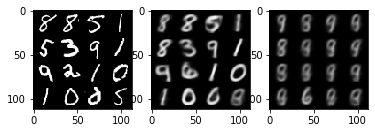

<Epoch:332/1000, Step:105/545>total_loss: 163.3015, kl_loss: 23.5084, recon_loss: 139.7931
<Epoch:333/1000, Step:060/545>total_loss: 164.7545, kl_loss: 24.4087, recon_loss: 140.3458
<Epoch:334/1000, Step:015/545>total_loss: 165.0012, kl_loss: 24.6520, recon_loss: 140.3492
<Epoch:334/1000, Step:515/545>total_loss: 169.2732, kl_loss: 22.8321, recon_loss: 146.4410
<Epoch:335/1000, Step:470/545>total_loss: 163.5378, kl_loss: 23.5066, recon_loss: 140.0312


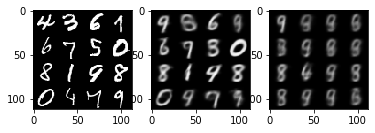

<Epoch:336/1000, Step:425/545>total_loss: 166.7538, kl_loss: 24.1349, recon_loss: 142.6188
<Epoch:337/1000, Step:380/545>total_loss: 161.3600, kl_loss: 24.1200, recon_loss: 137.2400
<Epoch:338/1000, Step:335/545>total_loss: 167.5691, kl_loss: 22.8698, recon_loss: 144.6993
<Epoch:339/1000, Step:290/545>total_loss: 170.3436, kl_loss: 24.4332, recon_loss: 145.9105
<Epoch:340/1000, Step:245/545>total_loss: 168.2849, kl_loss: 24.6821, recon_loss: 143.6028


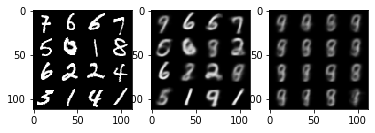

<Epoch:341/1000, Step:200/545>total_loss: 159.0950, kl_loss: 24.5478, recon_loss: 134.5472
<Epoch:342/1000, Step:155/545>total_loss: 166.2579, kl_loss: 23.3098, recon_loss: 142.9482
<Epoch:343/1000, Step:110/545>total_loss: 164.2016, kl_loss: 25.3927, recon_loss: 138.8088
<Epoch:344/1000, Step:065/545>total_loss: 168.8549, kl_loss: 22.8900, recon_loss: 145.9650
<Epoch:345/1000, Step:020/545>total_loss: 174.4800, kl_loss: 26.8332, recon_loss: 147.6468


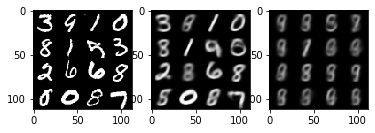

<Epoch:345/1000, Step:520/545>total_loss: 171.6677, kl_loss: 24.2262, recon_loss: 147.4415
<Epoch:346/1000, Step:475/545>total_loss: 170.1044, kl_loss: 24.8582, recon_loss: 145.2462
<Epoch:347/1000, Step:430/545>total_loss: 161.2199, kl_loss: 24.0058, recon_loss: 137.2141
<Epoch:348/1000, Step:385/545>total_loss: 172.1884, kl_loss: 25.1776, recon_loss: 147.0109
<Epoch:349/1000, Step:340/545>total_loss: 163.2737, kl_loss: 23.0366, recon_loss: 140.2371


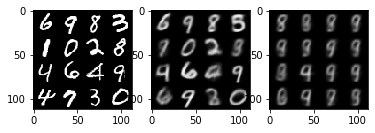

<Epoch:350/1000, Step:295/545>total_loss: 172.0817, kl_loss: 25.9241, recon_loss: 146.1576
<Epoch:351/1000, Step:250/545>total_loss: 171.8375, kl_loss: 24.3598, recon_loss: 147.4778
<Epoch:352/1000, Step:205/545>total_loss: 165.4501, kl_loss: 24.0491, recon_loss: 141.4010
<Epoch:353/1000, Step:160/545>total_loss: 172.9444, kl_loss: 25.7601, recon_loss: 147.1843
<Epoch:354/1000, Step:115/545>total_loss: 172.7621, kl_loss: 24.8907, recon_loss: 147.8714


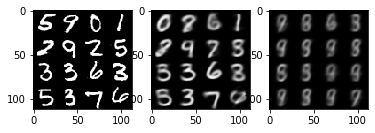

<Epoch:355/1000, Step:070/545>total_loss: 164.1183, kl_loss: 23.4418, recon_loss: 140.6765
<Epoch:356/1000, Step:025/545>total_loss: 164.9639, kl_loss: 23.8399, recon_loss: 141.1240
<Epoch:356/1000, Step:525/545>total_loss: 160.3667, kl_loss: 22.8358, recon_loss: 137.5309
<Epoch:357/1000, Step:480/545>total_loss: 165.6201, kl_loss: 23.5566, recon_loss: 142.0635
<Epoch:358/1000, Step:435/545>total_loss: 166.4038, kl_loss: 24.3726, recon_loss: 142.0312


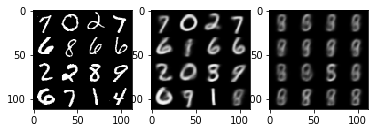

<Epoch:359/1000, Step:390/545>total_loss: 165.0056, kl_loss: 24.2889, recon_loss: 140.7167
<Epoch:360/1000, Step:345/545>total_loss: 164.0970, kl_loss: 26.0278, recon_loss: 138.0692
<Epoch:361/1000, Step:300/545>total_loss: 163.3472, kl_loss: 22.7466, recon_loss: 140.6006
<Epoch:362/1000, Step:255/545>total_loss: 167.1342, kl_loss: 25.6113, recon_loss: 141.5229
<Epoch:363/1000, Step:210/545>total_loss: 164.4737, kl_loss: 25.0673, recon_loss: 139.4063


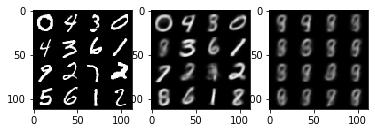

<Epoch:364/1000, Step:165/545>total_loss: 171.6336, kl_loss: 25.2336, recon_loss: 146.4000
<Epoch:365/1000, Step:120/545>total_loss: 163.4878, kl_loss: 22.7697, recon_loss: 140.7181
<Epoch:366/1000, Step:075/545>total_loss: 173.7618, kl_loss: 25.8956, recon_loss: 147.8662
<Epoch:367/1000, Step:030/545>total_loss: 171.1378, kl_loss: 25.1317, recon_loss: 146.0060
<Epoch:367/1000, Step:530/545>total_loss: 167.0789, kl_loss: 24.4625, recon_loss: 142.6165


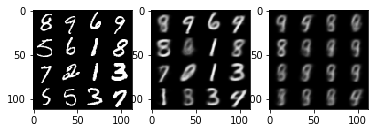

<Epoch:368/1000, Step:485/545>total_loss: 166.5955, kl_loss: 24.3468, recon_loss: 142.2487
<Epoch:369/1000, Step:440/545>total_loss: 165.9985, kl_loss: 23.9466, recon_loss: 142.0519
<Epoch:370/1000, Step:395/545>total_loss: 163.9200, kl_loss: 24.8581, recon_loss: 139.0618
<Epoch:371/1000, Step:350/545>total_loss: 165.5411, kl_loss: 25.2853, recon_loss: 140.2558
<Epoch:372/1000, Step:305/545>total_loss: 163.9933, kl_loss: 22.4422, recon_loss: 141.5511


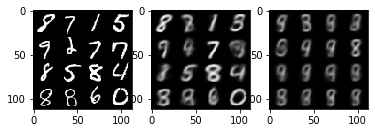

<Epoch:373/1000, Step:260/545>total_loss: 169.2068, kl_loss: 22.4378, recon_loss: 146.7690
<Epoch:374/1000, Step:215/545>total_loss: 167.0410, kl_loss: 24.2664, recon_loss: 142.7746
<Epoch:375/1000, Step:170/545>total_loss: 168.8385, kl_loss: 25.0583, recon_loss: 143.7802
<Epoch:376/1000, Step:125/545>total_loss: 170.2855, kl_loss: 23.1139, recon_loss: 147.1716
<Epoch:377/1000, Step:080/545>total_loss: 162.0521, kl_loss: 22.5960, recon_loss: 139.4561


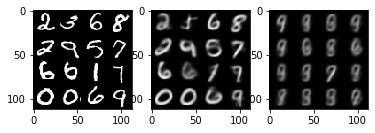

<Epoch:378/1000, Step:035/545>total_loss: 165.9581, kl_loss: 24.3104, recon_loss: 141.6477
<Epoch:378/1000, Step:535/545>total_loss: 164.6266, kl_loss: 23.0777, recon_loss: 141.5490
<Epoch:379/1000, Step:490/545>total_loss: 170.7549, kl_loss: 25.8269, recon_loss: 144.9280
<Epoch:380/1000, Step:445/545>total_loss: 171.2912, kl_loss: 25.1760, recon_loss: 146.1152
<Epoch:381/1000, Step:400/545>total_loss: 168.2585, kl_loss: 23.6790, recon_loss: 144.5795


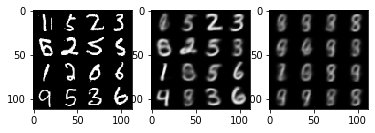

<Epoch:382/1000, Step:355/545>total_loss: 163.6040, kl_loss: 26.8135, recon_loss: 136.7905
<Epoch:383/1000, Step:310/545>total_loss: 163.8629, kl_loss: 22.6125, recon_loss: 141.2504
<Epoch:384/1000, Step:265/545>total_loss: 170.4148, kl_loss: 24.2249, recon_loss: 146.1899
<Epoch:385/1000, Step:220/545>total_loss: 170.1389, kl_loss: 24.0333, recon_loss: 146.1056
<Epoch:386/1000, Step:175/545>total_loss: 169.8723, kl_loss: 24.8960, recon_loss: 144.9762


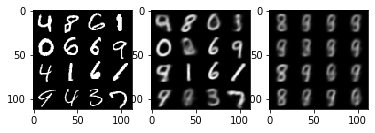

<Epoch:387/1000, Step:130/545>total_loss: 163.0457, kl_loss: 21.1309, recon_loss: 141.9148
<Epoch:388/1000, Step:085/545>total_loss: 175.5652, kl_loss: 25.4472, recon_loss: 150.1180
<Epoch:389/1000, Step:040/545>total_loss: 170.7688, kl_loss: 25.8512, recon_loss: 144.9176
<Epoch:389/1000, Step:540/545>total_loss: 171.8100, kl_loss: 24.4188, recon_loss: 147.3912
<Epoch:390/1000, Step:495/545>total_loss: 161.2401, kl_loss: 22.8794, recon_loss: 138.3607


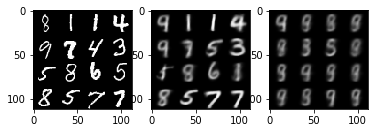

<Epoch:391/1000, Step:450/545>total_loss: 163.4977, kl_loss: 24.9502, recon_loss: 138.5475
<Epoch:392/1000, Step:405/545>total_loss: 168.9523, kl_loss: 23.7287, recon_loss: 145.2236
<Epoch:393/1000, Step:360/545>total_loss: 165.0987, kl_loss: 23.8968, recon_loss: 141.2019
<Epoch:394/1000, Step:315/545>total_loss: 166.7469, kl_loss: 22.4854, recon_loss: 144.2616
<Epoch:395/1000, Step:270/545>total_loss: 166.2457, kl_loss: 22.4024, recon_loss: 143.8433


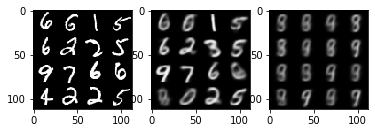

<Epoch:396/1000, Step:225/545>total_loss: 166.8381, kl_loss: 25.9376, recon_loss: 140.9005
<Epoch:397/1000, Step:180/545>total_loss: 169.0026, kl_loss: 24.5400, recon_loss: 144.4626
<Epoch:398/1000, Step:135/545>total_loss: 170.6458, kl_loss: 24.8863, recon_loss: 145.7595
<Epoch:399/1000, Step:090/545>total_loss: 159.9489, kl_loss: 24.6161, recon_loss: 135.3328
<Epoch:400/1000, Step:045/545>total_loss: 164.0233, kl_loss: 24.1416, recon_loss: 139.8817


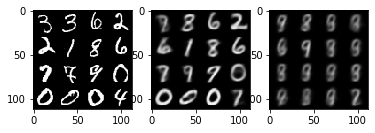

<Epoch:400/1000, Step:545/545>total_loss: 163.0889, kl_loss: 25.2001, recon_loss: 137.8888
<Epoch:401/1000, Step:500/545>total_loss: 165.9830, kl_loss: 22.1845, recon_loss: 143.7984
<Epoch:402/1000, Step:455/545>total_loss: 172.1852, kl_loss: 26.3357, recon_loss: 145.8495
<Epoch:403/1000, Step:410/545>total_loss: 171.5869, kl_loss: 24.8292, recon_loss: 146.7577
<Epoch:404/1000, Step:365/545>total_loss: 165.3166, kl_loss: 23.8046, recon_loss: 141.5121


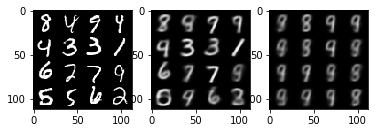

<Epoch:405/1000, Step:320/545>total_loss: 164.5329, kl_loss: 24.7463, recon_loss: 139.7867
<Epoch:406/1000, Step:275/545>total_loss: 167.1624, kl_loss: 26.0644, recon_loss: 141.0980
<Epoch:407/1000, Step:230/545>total_loss: 165.3383, kl_loss: 24.6202, recon_loss: 140.7182
<Epoch:408/1000, Step:185/545>total_loss: 160.4993, kl_loss: 23.4358, recon_loss: 137.0635
<Epoch:409/1000, Step:140/545>total_loss: 163.3196, kl_loss: 23.1203, recon_loss: 140.1994


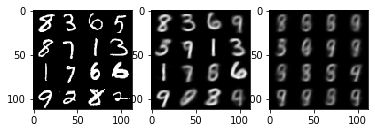

<Epoch:410/1000, Step:095/545>total_loss: 171.4745, kl_loss: 24.5525, recon_loss: 146.9220
<Epoch:411/1000, Step:050/545>total_loss: 176.3949, kl_loss: 26.2622, recon_loss: 150.1327
<Epoch:412/1000, Step:005/545>total_loss: 165.1391, kl_loss: 23.2906, recon_loss: 141.8486
<Epoch:412/1000, Step:505/545>total_loss: 167.0608, kl_loss: 24.9819, recon_loss: 142.0789
<Epoch:413/1000, Step:460/545>total_loss: 169.1659, kl_loss: 24.3414, recon_loss: 144.8245


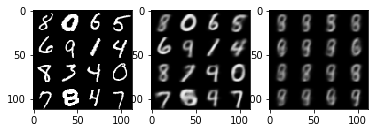

<Epoch:414/1000, Step:415/545>total_loss: 169.8716, kl_loss: 23.1249, recon_loss: 146.7467
<Epoch:415/1000, Step:370/545>total_loss: 166.7392, kl_loss: 23.2644, recon_loss: 143.4747
<Epoch:416/1000, Step:325/545>total_loss: 166.9849, kl_loss: 24.1610, recon_loss: 142.8239
<Epoch:417/1000, Step:280/545>total_loss: 171.1281, kl_loss: 23.2368, recon_loss: 147.8913
<Epoch:418/1000, Step:235/545>total_loss: 164.4794, kl_loss: 25.5481, recon_loss: 138.9313


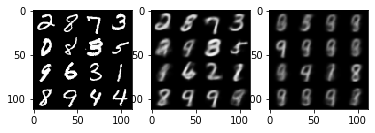

<Epoch:419/1000, Step:190/545>total_loss: 164.6378, kl_loss: 23.8681, recon_loss: 140.7698
<Epoch:420/1000, Step:145/545>total_loss: 170.6714, kl_loss: 26.0904, recon_loss: 144.5811
<Epoch:421/1000, Step:100/545>total_loss: 166.4634, kl_loss: 24.9115, recon_loss: 141.5520
<Epoch:422/1000, Step:055/545>total_loss: 165.2775, kl_loss: 23.9181, recon_loss: 141.3594
<Epoch:423/1000, Step:010/545>total_loss: 167.6914, kl_loss: 25.3752, recon_loss: 142.3162


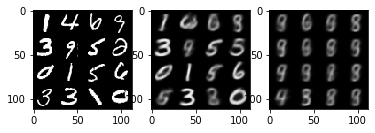

<Epoch:423/1000, Step:510/545>total_loss: 164.4684, kl_loss: 21.2632, recon_loss: 143.2053
<Epoch:424/1000, Step:465/545>total_loss: 158.7976, kl_loss: 24.3681, recon_loss: 134.4295
<Epoch:425/1000, Step:420/545>total_loss: 163.5527, kl_loss: 23.6859, recon_loss: 139.8668
<Epoch:426/1000, Step:375/545>total_loss: 171.4811, kl_loss: 23.4477, recon_loss: 148.0334
<Epoch:427/1000, Step:330/545>total_loss: 164.5251, kl_loss: 25.0765, recon_loss: 139.4487


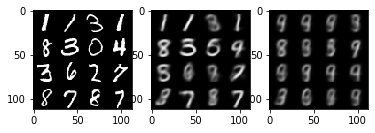

<Epoch:428/1000, Step:285/545>total_loss: 166.8860, kl_loss: 23.7731, recon_loss: 143.1129
<Epoch:429/1000, Step:240/545>total_loss: 168.0339, kl_loss: 25.7030, recon_loss: 142.3309
<Epoch:430/1000, Step:195/545>total_loss: 162.6209, kl_loss: 24.4878, recon_loss: 138.1332
<Epoch:431/1000, Step:150/545>total_loss: 170.0118, kl_loss: 26.4626, recon_loss: 143.5492
<Epoch:432/1000, Step:105/545>total_loss: 169.9402, kl_loss: 25.0342, recon_loss: 144.9059


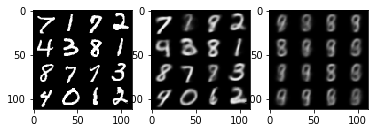

<Epoch:433/1000, Step:060/545>total_loss: 169.8939, kl_loss: 24.2054, recon_loss: 145.6885
<Epoch:434/1000, Step:015/545>total_loss: 170.8608, kl_loss: 24.2319, recon_loss: 146.6289
<Epoch:434/1000, Step:515/545>total_loss: 170.7352, kl_loss: 24.5382, recon_loss: 146.1969
<Epoch:435/1000, Step:470/545>total_loss: 166.7447, kl_loss: 25.5482, recon_loss: 141.1965
<Epoch:436/1000, Step:425/545>total_loss: 162.4696, kl_loss: 23.8958, recon_loss: 138.5738


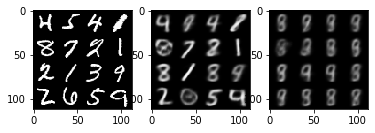

<Epoch:437/1000, Step:380/545>total_loss: 166.6625, kl_loss: 23.5795, recon_loss: 143.0831
<Epoch:438/1000, Step:335/545>total_loss: 167.8624, kl_loss: 24.9853, recon_loss: 142.8771
<Epoch:439/1000, Step:290/545>total_loss: 164.7915, kl_loss: 25.5387, recon_loss: 139.2528
<Epoch:440/1000, Step:245/545>total_loss: 164.4592, kl_loss: 22.8589, recon_loss: 141.6003
<Epoch:441/1000, Step:200/545>total_loss: 168.9333, kl_loss: 24.9858, recon_loss: 143.9475


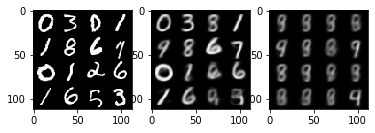

<Epoch:442/1000, Step:155/545>total_loss: 160.3617, kl_loss: 22.9310, recon_loss: 137.4306
<Epoch:443/1000, Step:110/545>total_loss: 165.6805, kl_loss: 23.9108, recon_loss: 141.7697
<Epoch:444/1000, Step:065/545>total_loss: 172.8001, kl_loss: 25.2163, recon_loss: 147.5838
<Epoch:445/1000, Step:020/545>total_loss: 170.6673, kl_loss: 24.9231, recon_loss: 145.7441
<Epoch:445/1000, Step:520/545>total_loss: 166.4933, kl_loss: 24.5711, recon_loss: 141.9222


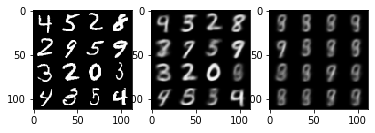

<Epoch:446/1000, Step:475/545>total_loss: 167.7691, kl_loss: 25.5921, recon_loss: 142.1770
<Epoch:447/1000, Step:430/545>total_loss: 169.4240, kl_loss: 24.4402, recon_loss: 144.9837
<Epoch:448/1000, Step:385/545>total_loss: 169.9762, kl_loss: 26.5970, recon_loss: 143.3792
<Epoch:449/1000, Step:340/545>total_loss: 166.6117, kl_loss: 25.4980, recon_loss: 141.1137
<Epoch:450/1000, Step:295/545>total_loss: 166.5399, kl_loss: 22.3210, recon_loss: 144.2190


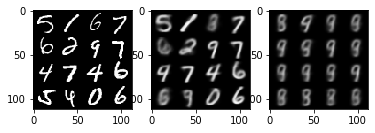

<Epoch:451/1000, Step:250/545>total_loss: 160.9753, kl_loss: 23.3168, recon_loss: 137.6585
<Epoch:452/1000, Step:205/545>total_loss: 166.1673, kl_loss: 25.0345, recon_loss: 141.1328
<Epoch:453/1000, Step:160/545>total_loss: 161.2387, kl_loss: 24.4499, recon_loss: 136.7888
<Epoch:454/1000, Step:115/545>total_loss: 164.5477, kl_loss: 23.5843, recon_loss: 140.9635
<Epoch:455/1000, Step:070/545>total_loss: 162.8152, kl_loss: 23.7292, recon_loss: 139.0860


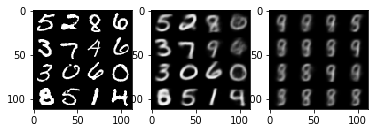

<Epoch:456/1000, Step:025/545>total_loss: 169.2345, kl_loss: 24.5850, recon_loss: 144.6495
<Epoch:456/1000, Step:525/545>total_loss: 164.8951, kl_loss: 24.9963, recon_loss: 139.8988
<Epoch:457/1000, Step:480/545>total_loss: 162.4335, kl_loss: 23.3655, recon_loss: 139.0680
<Epoch:458/1000, Step:435/545>total_loss: 168.1940, kl_loss: 25.7272, recon_loss: 142.4668
<Epoch:459/1000, Step:390/545>total_loss: 159.1025, kl_loss: 23.6883, recon_loss: 135.4142


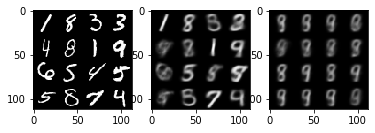

<Epoch:460/1000, Step:345/545>total_loss: 172.4781, kl_loss: 25.3145, recon_loss: 147.1635
<Epoch:461/1000, Step:300/545>total_loss: 171.0568, kl_loss: 25.4934, recon_loss: 145.5634
<Epoch:462/1000, Step:255/545>total_loss: 172.9155, kl_loss: 24.9055, recon_loss: 148.0100
<Epoch:463/1000, Step:210/545>total_loss: 167.8301, kl_loss: 25.6189, recon_loss: 142.2112
<Epoch:464/1000, Step:165/545>total_loss: 168.3777, kl_loss: 24.4331, recon_loss: 143.9446


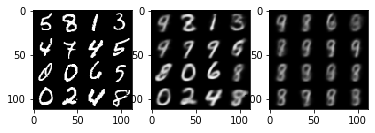

<Epoch:465/1000, Step:120/545>total_loss: 164.3590, kl_loss: 23.9595, recon_loss: 140.3995
<Epoch:466/1000, Step:075/545>total_loss: 166.1624, kl_loss: 25.3043, recon_loss: 140.8581
<Epoch:467/1000, Step:030/545>total_loss: 167.6164, kl_loss: 24.7164, recon_loss: 142.9000
<Epoch:467/1000, Step:530/545>total_loss: 171.4740, kl_loss: 25.6257, recon_loss: 145.8483
<Epoch:468/1000, Step:485/545>total_loss: 164.5081, kl_loss: 25.9662, recon_loss: 138.5419


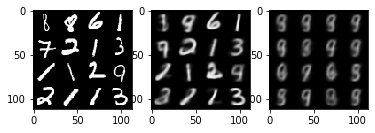

<Epoch:469/1000, Step:440/545>total_loss: 157.1472, kl_loss: 24.1703, recon_loss: 132.9769
<Epoch:470/1000, Step:395/545>total_loss: 164.4945, kl_loss: 24.0842, recon_loss: 140.4103
<Epoch:471/1000, Step:350/545>total_loss: 171.5072, kl_loss: 25.7377, recon_loss: 145.7695
<Epoch:472/1000, Step:305/545>total_loss: 162.1682, kl_loss: 24.8018, recon_loss: 137.3664
<Epoch:473/1000, Step:260/545>total_loss: 166.5368, kl_loss: 24.6584, recon_loss: 141.8784


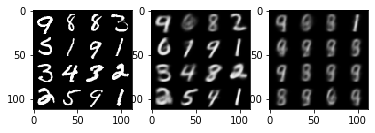

<Epoch:474/1000, Step:215/545>total_loss: 173.9221, kl_loss: 25.7872, recon_loss: 148.1349
<Epoch:475/1000, Step:170/545>total_loss: 166.7646, kl_loss: 24.0070, recon_loss: 142.7577
<Epoch:476/1000, Step:125/545>total_loss: 165.9633, kl_loss: 25.4291, recon_loss: 140.5342
<Epoch:477/1000, Step:080/545>total_loss: 172.8591, kl_loss: 24.3285, recon_loss: 148.5306
<Epoch:478/1000, Step:035/545>total_loss: 168.6152, kl_loss: 24.3378, recon_loss: 144.2774


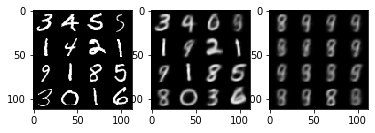

<Epoch:478/1000, Step:535/545>total_loss: 168.2014, kl_loss: 24.2251, recon_loss: 143.9763
<Epoch:479/1000, Step:490/545>total_loss: 171.4371, kl_loss: 25.3686, recon_loss: 146.0684
<Epoch:480/1000, Step:445/545>total_loss: 169.8434, kl_loss: 25.9508, recon_loss: 143.8926
<Epoch:481/1000, Step:400/545>total_loss: 170.5693, kl_loss: 24.2937, recon_loss: 146.2757
<Epoch:482/1000, Step:355/545>total_loss: 168.3846, kl_loss: 23.6556, recon_loss: 144.7290


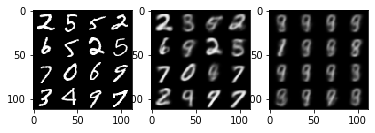

<Epoch:483/1000, Step:310/545>total_loss: 173.5867, kl_loss: 25.9736, recon_loss: 147.6131
<Epoch:484/1000, Step:265/545>total_loss: 168.3313, kl_loss: 24.6152, recon_loss: 143.7161
<Epoch:485/1000, Step:220/545>total_loss: 166.1850, kl_loss: 24.8182, recon_loss: 141.3668
<Epoch:486/1000, Step:175/545>total_loss: 175.2475, kl_loss: 26.3432, recon_loss: 148.9044
<Epoch:487/1000, Step:130/545>total_loss: 171.0255, kl_loss: 24.2049, recon_loss: 146.8206


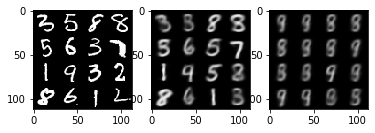

<Epoch:488/1000, Step:085/545>total_loss: 163.2349, kl_loss: 22.4408, recon_loss: 140.7942
<Epoch:489/1000, Step:040/545>total_loss: 164.6062, kl_loss: 25.3853, recon_loss: 139.2209
<Epoch:489/1000, Step:540/545>total_loss: 175.0104, kl_loss: 24.9447, recon_loss: 150.0657
<Epoch:490/1000, Step:495/545>total_loss: 170.7876, kl_loss: 27.5699, recon_loss: 143.2177
<Epoch:491/1000, Step:450/545>total_loss: 169.2114, kl_loss: 25.2047, recon_loss: 144.0066


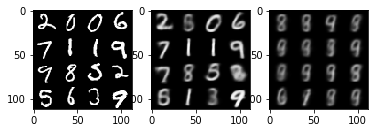

<Epoch:492/1000, Step:405/545>total_loss: 162.4124, kl_loss: 23.9514, recon_loss: 138.4610
<Epoch:493/1000, Step:360/545>total_loss: 164.1225, kl_loss: 24.8534, recon_loss: 139.2691
<Epoch:494/1000, Step:315/545>total_loss: 170.4341, kl_loss: 25.6554, recon_loss: 144.7787
<Epoch:495/1000, Step:270/545>total_loss: 171.2532, kl_loss: 23.8647, recon_loss: 147.3885
<Epoch:496/1000, Step:225/545>total_loss: 166.7363, kl_loss: 24.2491, recon_loss: 142.4872


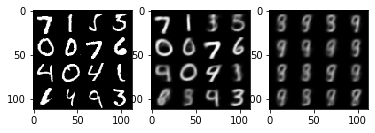

<Epoch:497/1000, Step:180/545>total_loss: 167.4314, kl_loss: 25.0478, recon_loss: 142.3836
<Epoch:498/1000, Step:135/545>total_loss: 161.5764, kl_loss: 23.2772, recon_loss: 138.2993
<Epoch:499/1000, Step:090/545>total_loss: 163.8922, kl_loss: 25.4234, recon_loss: 138.4687
<Epoch:500/1000, Step:045/545>total_loss: 165.1389, kl_loss: 24.8424, recon_loss: 140.2965
<Epoch:500/1000, Step:545/545>total_loss: 169.7676, kl_loss: 25.4882, recon_loss: 144.2795


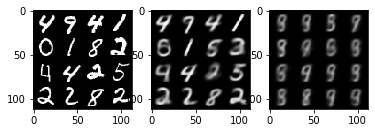

<Epoch:501/1000, Step:500/545>total_loss: 159.2078, kl_loss: 25.6104, recon_loss: 133.5975
<Epoch:502/1000, Step:455/545>total_loss: 159.1091, kl_loss: 24.5018, recon_loss: 134.6073
<Epoch:503/1000, Step:410/545>total_loss: 167.6762, kl_loss: 24.5106, recon_loss: 143.1657
<Epoch:504/1000, Step:365/545>total_loss: 165.3134, kl_loss: 24.8002, recon_loss: 140.5132
<Epoch:505/1000, Step:320/545>total_loss: 159.5875, kl_loss: 25.5735, recon_loss: 134.0141


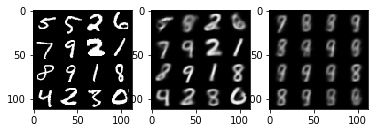

<Epoch:506/1000, Step:275/545>total_loss: 163.2998, kl_loss: 24.3903, recon_loss: 138.9095
<Epoch:507/1000, Step:230/545>total_loss: 166.8580, kl_loss: 24.5940, recon_loss: 142.2640
<Epoch:508/1000, Step:185/545>total_loss: 167.8420, kl_loss: 25.8632, recon_loss: 141.9787
<Epoch:509/1000, Step:140/545>total_loss: 165.0546, kl_loss: 24.6319, recon_loss: 140.4227
<Epoch:510/1000, Step:095/545>total_loss: 166.1934, kl_loss: 25.0550, recon_loss: 141.1384


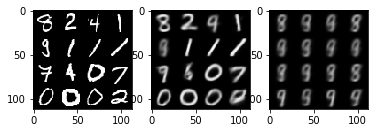

<Epoch:511/1000, Step:050/545>total_loss: 163.7017, kl_loss: 24.2970, recon_loss: 139.4047
<Epoch:512/1000, Step:005/545>total_loss: 168.0127, kl_loss: 24.4252, recon_loss: 143.5874
<Epoch:512/1000, Step:505/545>total_loss: 169.9873, kl_loss: 25.2565, recon_loss: 144.7308
<Epoch:513/1000, Step:460/545>total_loss: 164.3272, kl_loss: 24.9739, recon_loss: 139.3533
<Epoch:514/1000, Step:415/545>total_loss: 167.9362, kl_loss: 26.0377, recon_loss: 141.8986


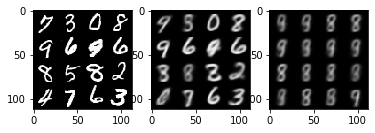

<Epoch:515/1000, Step:370/545>total_loss: 168.6804, kl_loss: 24.9978, recon_loss: 143.6826
<Epoch:516/1000, Step:325/545>total_loss: 165.4852, kl_loss: 23.9606, recon_loss: 141.5246
<Epoch:517/1000, Step:280/545>total_loss: 170.6852, kl_loss: 25.4411, recon_loss: 145.2441
<Epoch:518/1000, Step:235/545>total_loss: 163.0055, kl_loss: 24.1632, recon_loss: 138.8423
<Epoch:519/1000, Step:190/545>total_loss: 171.6999, kl_loss: 26.0214, recon_loss: 145.6785


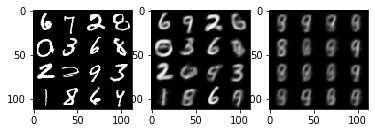

<Epoch:520/1000, Step:145/545>total_loss: 173.1398, kl_loss: 26.9510, recon_loss: 146.1888
<Epoch:521/1000, Step:100/545>total_loss: 172.4996, kl_loss: 24.6992, recon_loss: 147.8004
<Epoch:522/1000, Step:055/545>total_loss: 171.9759, kl_loss: 26.2331, recon_loss: 145.7427
<Epoch:523/1000, Step:010/545>total_loss: 167.1182, kl_loss: 24.5526, recon_loss: 142.5657
<Epoch:523/1000, Step:510/545>total_loss: 162.0248, kl_loss: 23.6188, recon_loss: 138.4060


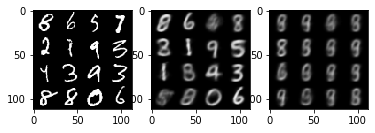

<Epoch:524/1000, Step:465/545>total_loss: 169.8338, kl_loss: 24.4282, recon_loss: 145.4056
<Epoch:525/1000, Step:420/545>total_loss: 172.3319, kl_loss: 25.4653, recon_loss: 146.8666
<Epoch:526/1000, Step:375/545>total_loss: 162.7727, kl_loss: 23.2577, recon_loss: 139.5150
<Epoch:527/1000, Step:330/545>total_loss: 161.8555, kl_loss: 24.2392, recon_loss: 137.6163
<Epoch:528/1000, Step:285/545>total_loss: 166.8142, kl_loss: 25.5347, recon_loss: 141.2795


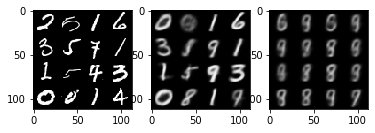

<Epoch:529/1000, Step:240/545>total_loss: 162.6266, kl_loss: 22.7301, recon_loss: 139.8964
<Epoch:530/1000, Step:195/545>total_loss: 172.9988, kl_loss: 25.0085, recon_loss: 147.9904
<Epoch:531/1000, Step:150/545>total_loss: 162.2771, kl_loss: 23.6128, recon_loss: 138.6643
<Epoch:532/1000, Step:105/545>total_loss: 164.1028, kl_loss: 25.2103, recon_loss: 138.8926
<Epoch:533/1000, Step:060/545>total_loss: 164.8041, kl_loss: 25.0149, recon_loss: 139.7892


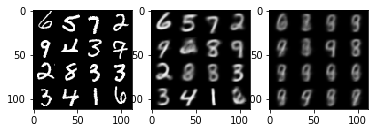

<Epoch:534/1000, Step:015/545>total_loss: 171.7930, kl_loss: 24.6029, recon_loss: 147.1901
<Epoch:534/1000, Step:515/545>total_loss: 165.4133, kl_loss: 25.6617, recon_loss: 139.7516
<Epoch:535/1000, Step:470/545>total_loss: 169.0485, kl_loss: 23.7344, recon_loss: 145.3141
<Epoch:536/1000, Step:425/545>total_loss: 170.0176, kl_loss: 25.3051, recon_loss: 144.7124
<Epoch:537/1000, Step:380/545>total_loss: 170.3070, kl_loss: 26.0859, recon_loss: 144.2211


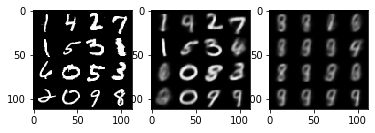

<Epoch:538/1000, Step:335/545>total_loss: 169.2435, kl_loss: 25.1389, recon_loss: 144.1046
<Epoch:539/1000, Step:290/545>total_loss: 166.8690, kl_loss: 27.0138, recon_loss: 139.8553
<Epoch:540/1000, Step:245/545>total_loss: 172.3899, kl_loss: 25.1730, recon_loss: 147.2169
<Epoch:541/1000, Step:200/545>total_loss: 173.3422, kl_loss: 27.0050, recon_loss: 146.3372
<Epoch:542/1000, Step:155/545>total_loss: 168.4214, kl_loss: 25.0814, recon_loss: 143.3400


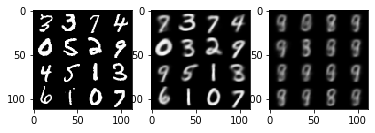

<Epoch:543/1000, Step:110/545>total_loss: 168.3713, kl_loss: 24.4964, recon_loss: 143.8749
<Epoch:544/1000, Step:065/545>total_loss: 170.0449, kl_loss: 25.7885, recon_loss: 144.2564
<Epoch:545/1000, Step:020/545>total_loss: 163.5782, kl_loss: 23.0306, recon_loss: 140.5475
<Epoch:545/1000, Step:520/545>total_loss: 167.6382, kl_loss: 23.5681, recon_loss: 144.0701
<Epoch:546/1000, Step:475/545>total_loss: 165.4521, kl_loss: 25.2036, recon_loss: 140.2486


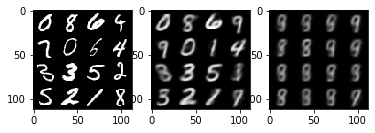

<Epoch:547/1000, Step:430/545>total_loss: 169.0168, kl_loss: 24.8236, recon_loss: 144.1932
<Epoch:548/1000, Step:385/545>total_loss: 163.2715, kl_loss: 23.7868, recon_loss: 139.4847
<Epoch:549/1000, Step:340/545>total_loss: 164.3443, kl_loss: 23.9014, recon_loss: 140.4429
<Epoch:550/1000, Step:295/545>total_loss: 167.1471, kl_loss: 26.1600, recon_loss: 140.9871
<Epoch:551/1000, Step:250/545>total_loss: 167.8820, kl_loss: 24.3056, recon_loss: 143.5764


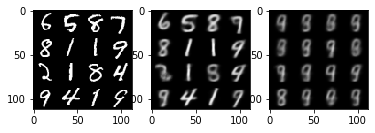

<Epoch:552/1000, Step:205/545>total_loss: 175.6042, kl_loss: 26.0067, recon_loss: 149.5976
<Epoch:553/1000, Step:160/545>total_loss: 155.5376, kl_loss: 23.9397, recon_loss: 131.5979
<Epoch:554/1000, Step:115/545>total_loss: 166.0144, kl_loss: 24.1914, recon_loss: 141.8230
<Epoch:555/1000, Step:070/545>total_loss: 172.9911, kl_loss: 23.6879, recon_loss: 149.3032
<Epoch:556/1000, Step:025/545>total_loss: 171.6456, kl_loss: 24.2993, recon_loss: 147.3463


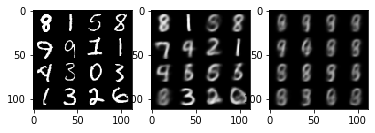

<Epoch:556/1000, Step:525/545>total_loss: 161.5958, kl_loss: 25.3710, recon_loss: 136.2248
<Epoch:557/1000, Step:480/545>total_loss: 168.1736, kl_loss: 24.1999, recon_loss: 143.9737
<Epoch:558/1000, Step:435/545>total_loss: 168.0719, kl_loss: 24.9311, recon_loss: 143.1408
<Epoch:559/1000, Step:390/545>total_loss: 166.8058, kl_loss: 25.1231, recon_loss: 141.6827
<Epoch:560/1000, Step:345/545>total_loss: 162.4735, kl_loss: 24.2895, recon_loss: 138.1840


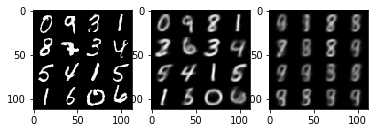

<Epoch:561/1000, Step:300/545>total_loss: 170.3345, kl_loss: 24.7114, recon_loss: 145.6231
<Epoch:562/1000, Step:255/545>total_loss: 176.0500, kl_loss: 25.8025, recon_loss: 150.2475
<Epoch:563/1000, Step:210/545>total_loss: 167.0492, kl_loss: 23.3539, recon_loss: 143.6953
<Epoch:564/1000, Step:165/545>total_loss: 169.7921, kl_loss: 25.9480, recon_loss: 143.8441
<Epoch:565/1000, Step:120/545>total_loss: 163.4826, kl_loss: 25.2533, recon_loss: 138.2293


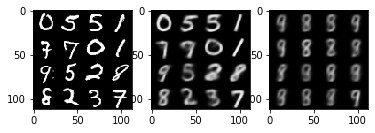

<Epoch:566/1000, Step:075/545>total_loss: 167.2936, kl_loss: 24.7060, recon_loss: 142.5876
<Epoch:567/1000, Step:030/545>total_loss: 166.0363, kl_loss: 24.4599, recon_loss: 141.5765
<Epoch:567/1000, Step:530/545>total_loss: 170.9900, kl_loss: 24.4613, recon_loss: 146.5287
<Epoch:568/1000, Step:485/545>total_loss: 168.6509, kl_loss: 25.6876, recon_loss: 142.9633
<Epoch:569/1000, Step:440/545>total_loss: 170.4642, kl_loss: 24.9874, recon_loss: 145.4769


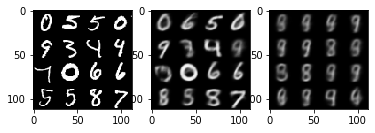

<Epoch:570/1000, Step:395/545>total_loss: 164.6084, kl_loss: 24.7413, recon_loss: 139.8671
<Epoch:571/1000, Step:350/545>total_loss: 165.7155, kl_loss: 23.7031, recon_loss: 142.0123
<Epoch:572/1000, Step:305/545>total_loss: 164.5912, kl_loss: 23.8859, recon_loss: 140.7053
<Epoch:573/1000, Step:260/545>total_loss: 166.9796, kl_loss: 24.3870, recon_loss: 142.5926
<Epoch:574/1000, Step:215/545>total_loss: 176.9176, kl_loss: 27.3879, recon_loss: 149.5297


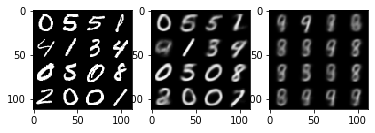

<Epoch:575/1000, Step:170/545>total_loss: 163.5689, kl_loss: 24.0768, recon_loss: 139.4922
<Epoch:576/1000, Step:125/545>total_loss: 167.1300, kl_loss: 23.6491, recon_loss: 143.4809
<Epoch:577/1000, Step:080/545>total_loss: 167.6701, kl_loss: 23.8584, recon_loss: 143.8117
<Epoch:578/1000, Step:035/545>total_loss: 162.7132, kl_loss: 23.8093, recon_loss: 138.9039
<Epoch:578/1000, Step:535/545>total_loss: 159.4955, kl_loss: 24.1204, recon_loss: 135.3752


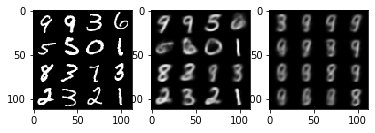

<Epoch:579/1000, Step:490/545>total_loss: 169.0182, kl_loss: 24.2001, recon_loss: 144.8181
<Epoch:580/1000, Step:445/545>total_loss: 157.0196, kl_loss: 23.9242, recon_loss: 133.0953
<Epoch:581/1000, Step:400/545>total_loss: 169.0111, kl_loss: 26.5647, recon_loss: 142.4464
<Epoch:582/1000, Step:355/545>total_loss: 162.1372, kl_loss: 25.4338, recon_loss: 136.7034
<Epoch:583/1000, Step:310/545>total_loss: 165.5553, kl_loss: 23.5171, recon_loss: 142.0383


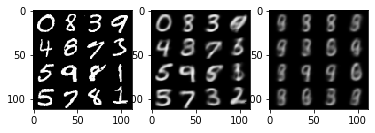

<Epoch:584/1000, Step:265/545>total_loss: 164.0588, kl_loss: 25.9548, recon_loss: 138.1040
<Epoch:585/1000, Step:220/545>total_loss: 164.5726, kl_loss: 23.5720, recon_loss: 141.0005
<Epoch:586/1000, Step:175/545>total_loss: 172.1040, kl_loss: 25.5144, recon_loss: 146.5896
<Epoch:587/1000, Step:130/545>total_loss: 171.5808, kl_loss: 26.4860, recon_loss: 145.0948
<Epoch:588/1000, Step:085/545>total_loss: 170.4422, kl_loss: 23.6088, recon_loss: 146.8334


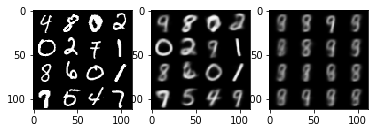

<Epoch:589/1000, Step:040/545>total_loss: 160.3259, kl_loss: 23.1499, recon_loss: 137.1760
<Epoch:589/1000, Step:540/545>total_loss: 172.5642, kl_loss: 24.2699, recon_loss: 148.2943
<Epoch:590/1000, Step:495/545>total_loss: 164.8815, kl_loss: 26.6335, recon_loss: 138.2480
<Epoch:591/1000, Step:450/545>total_loss: 172.9639, kl_loss: 25.3887, recon_loss: 147.5751
<Epoch:592/1000, Step:405/545>total_loss: 171.6504, kl_loss: 26.4550, recon_loss: 145.1954


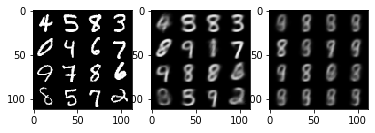

<Epoch:593/1000, Step:360/545>total_loss: 167.7265, kl_loss: 24.6921, recon_loss: 143.0344
<Epoch:594/1000, Step:315/545>total_loss: 164.9494, kl_loss: 22.6386, recon_loss: 142.3108
<Epoch:595/1000, Step:270/545>total_loss: 160.7101, kl_loss: 23.4310, recon_loss: 137.2791
<Epoch:596/1000, Step:225/545>total_loss: 162.3933, kl_loss: 25.1968, recon_loss: 137.1965
<Epoch:597/1000, Step:180/545>total_loss: 160.3491, kl_loss: 24.1875, recon_loss: 136.1615


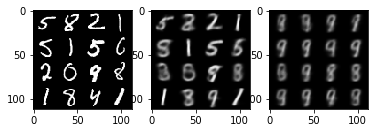

<Epoch:598/1000, Step:135/545>total_loss: 167.2788, kl_loss: 25.4421, recon_loss: 141.8367
<Epoch:599/1000, Step:090/545>total_loss: 168.6367, kl_loss: 26.1662, recon_loss: 142.4706
<Epoch:600/1000, Step:045/545>total_loss: 164.4252, kl_loss: 24.1949, recon_loss: 140.2303
<Epoch:600/1000, Step:545/545>total_loss: 163.5135, kl_loss: 24.7159, recon_loss: 138.7976
<Epoch:601/1000, Step:500/545>total_loss: 169.0596, kl_loss: 24.8802, recon_loss: 144.1794


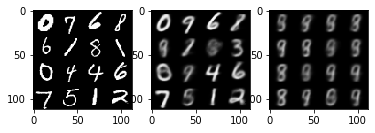

<Epoch:602/1000, Step:455/545>total_loss: 170.5385, kl_loss: 22.8379, recon_loss: 147.7006
<Epoch:603/1000, Step:410/545>total_loss: 166.0661, kl_loss: 24.7010, recon_loss: 141.3651
<Epoch:604/1000, Step:365/545>total_loss: 165.3670, kl_loss: 25.3734, recon_loss: 139.9935
<Epoch:605/1000, Step:320/545>total_loss: 171.1783, kl_loss: 25.4930, recon_loss: 145.6853
<Epoch:606/1000, Step:275/545>total_loss: 166.2829, kl_loss: 24.2275, recon_loss: 142.0554


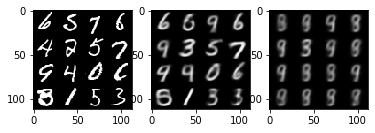

<Epoch:607/1000, Step:230/545>total_loss: 164.7195, kl_loss: 24.1292, recon_loss: 140.5903
<Epoch:608/1000, Step:185/545>total_loss: 166.4080, kl_loss: 25.4810, recon_loss: 140.9271
<Epoch:609/1000, Step:140/545>total_loss: 172.7220, kl_loss: 25.0400, recon_loss: 147.6820
<Epoch:610/1000, Step:095/545>total_loss: 163.0676, kl_loss: 24.8131, recon_loss: 138.2545
<Epoch:611/1000, Step:050/545>total_loss: 168.3943, kl_loss: 24.9258, recon_loss: 143.4685


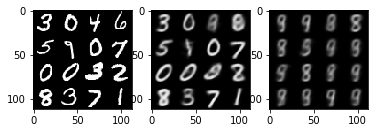

<Epoch:612/1000, Step:005/545>total_loss: 169.7044, kl_loss: 24.6628, recon_loss: 145.0417
<Epoch:612/1000, Step:505/545>total_loss: 166.9042, kl_loss: 25.8948, recon_loss: 141.0094
<Epoch:613/1000, Step:460/545>total_loss: 165.9015, kl_loss: 24.8577, recon_loss: 141.0439
<Epoch:614/1000, Step:415/545>total_loss: 164.1144, kl_loss: 24.3208, recon_loss: 139.7937
<Epoch:615/1000, Step:370/545>total_loss: 167.0080, kl_loss: 24.8621, recon_loss: 142.1459


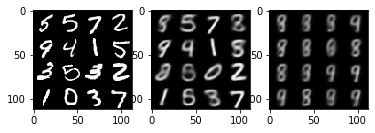

<Epoch:616/1000, Step:325/545>total_loss: 166.7464, kl_loss: 24.8741, recon_loss: 141.8723
<Epoch:617/1000, Step:280/545>total_loss: 167.8487, kl_loss: 26.5197, recon_loss: 141.3290
<Epoch:618/1000, Step:235/545>total_loss: 165.9713, kl_loss: 24.6375, recon_loss: 141.3338
<Epoch:619/1000, Step:190/545>total_loss: 162.1966, kl_loss: 22.9192, recon_loss: 139.2773
<Epoch:620/1000, Step:145/545>total_loss: 176.7325, kl_loss: 24.7883, recon_loss: 151.9442


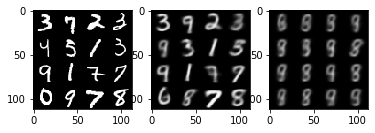

<Epoch:621/1000, Step:100/545>total_loss: 166.9407, kl_loss: 25.7284, recon_loss: 141.2123
<Epoch:622/1000, Step:055/545>total_loss: 163.9525, kl_loss: 24.2733, recon_loss: 139.6792
<Epoch:623/1000, Step:010/545>total_loss: 172.6425, kl_loss: 25.4389, recon_loss: 147.2037
<Epoch:623/1000, Step:510/545>total_loss: 166.1325, kl_loss: 24.6116, recon_loss: 141.5209
<Epoch:624/1000, Step:465/545>total_loss: 163.4637, kl_loss: 25.7052, recon_loss: 137.7585


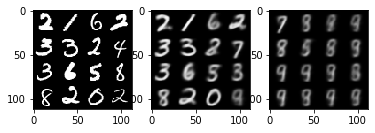

<Epoch:625/1000, Step:420/545>total_loss: 166.9367, kl_loss: 26.5961, recon_loss: 140.3406
<Epoch:626/1000, Step:375/545>total_loss: 163.0801, kl_loss: 22.5326, recon_loss: 140.5475
<Epoch:627/1000, Step:330/545>total_loss: 169.9910, kl_loss: 23.0139, recon_loss: 146.9771
<Epoch:628/1000, Step:285/545>total_loss: 169.8676, kl_loss: 25.3916, recon_loss: 144.4760
<Epoch:629/1000, Step:240/545>total_loss: 164.0480, kl_loss: 23.4735, recon_loss: 140.5745


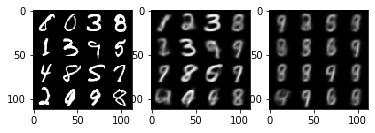

<Epoch:630/1000, Step:195/545>total_loss: 157.8993, kl_loss: 24.8463, recon_loss: 133.0531
<Epoch:631/1000, Step:150/545>total_loss: 160.9961, kl_loss: 23.7372, recon_loss: 137.2590
<Epoch:632/1000, Step:105/545>total_loss: 166.9429, kl_loss: 24.8164, recon_loss: 142.1264
<Epoch:633/1000, Step:060/545>total_loss: 157.0022, kl_loss: 23.4229, recon_loss: 133.5793
<Epoch:634/1000, Step:015/545>total_loss: 159.2041, kl_loss: 23.2735, recon_loss: 135.9306


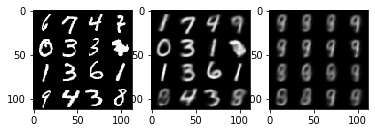

<Epoch:634/1000, Step:515/545>total_loss: 165.9533, kl_loss: 24.7882, recon_loss: 141.1650
<Epoch:635/1000, Step:470/545>total_loss: 163.8155, kl_loss: 24.9691, recon_loss: 138.8464
<Epoch:636/1000, Step:425/545>total_loss: 160.1531, kl_loss: 24.4765, recon_loss: 135.6767
<Epoch:637/1000, Step:380/545>total_loss: 162.4193, kl_loss: 24.6299, recon_loss: 137.7894
<Epoch:638/1000, Step:335/545>total_loss: 165.2470, kl_loss: 23.7950, recon_loss: 141.4520


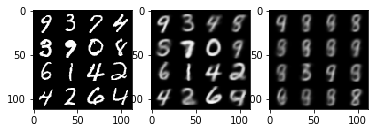

<Epoch:639/1000, Step:290/545>total_loss: 171.9852, kl_loss: 26.4191, recon_loss: 145.5662
<Epoch:640/1000, Step:245/545>total_loss: 167.7815, kl_loss: 25.5806, recon_loss: 142.2009
<Epoch:641/1000, Step:200/545>total_loss: 162.0718, kl_loss: 25.3426, recon_loss: 136.7291
<Epoch:642/1000, Step:155/545>total_loss: 171.4232, kl_loss: 26.1566, recon_loss: 145.2666
<Epoch:643/1000, Step:110/545>total_loss: 165.9077, kl_loss: 25.3022, recon_loss: 140.6055


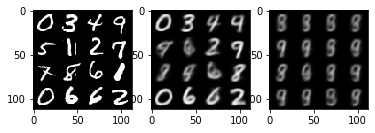

<Epoch:644/1000, Step:065/545>total_loss: 170.7000, kl_loss: 25.6787, recon_loss: 145.0213
<Epoch:645/1000, Step:020/545>total_loss: 167.5954, kl_loss: 23.7889, recon_loss: 143.8065
<Epoch:645/1000, Step:520/545>total_loss: 165.4625, kl_loss: 25.9190, recon_loss: 139.5436
<Epoch:646/1000, Step:475/545>total_loss: 169.5900, kl_loss: 25.2731, recon_loss: 144.3169
<Epoch:647/1000, Step:430/545>total_loss: 167.0476, kl_loss: 22.4821, recon_loss: 144.5655


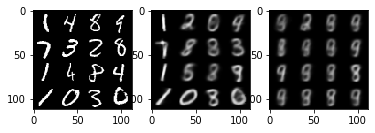

<Epoch:648/1000, Step:385/545>total_loss: 166.7634, kl_loss: 24.1319, recon_loss: 142.6315
<Epoch:649/1000, Step:340/545>total_loss: 164.0450, kl_loss: 26.1252, recon_loss: 137.9198
<Epoch:650/1000, Step:295/545>total_loss: 170.4442, kl_loss: 26.2663, recon_loss: 144.1779
<Epoch:651/1000, Step:250/545>total_loss: 162.6907, kl_loss: 26.4922, recon_loss: 136.1985
<Epoch:652/1000, Step:205/545>total_loss: 165.0078, kl_loss: 23.1648, recon_loss: 141.8430


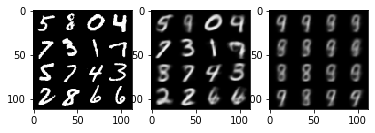

<Epoch:653/1000, Step:160/545>total_loss: 166.9361, kl_loss: 24.0366, recon_loss: 142.8995
<Epoch:654/1000, Step:115/545>total_loss: 167.1895, kl_loss: 24.1737, recon_loss: 143.0158
<Epoch:655/1000, Step:070/545>total_loss: 173.0121, kl_loss: 27.0436, recon_loss: 145.9685
<Epoch:656/1000, Step:025/545>total_loss: 165.7096, kl_loss: 25.0047, recon_loss: 140.7048
<Epoch:656/1000, Step:525/545>total_loss: 169.3705, kl_loss: 25.0678, recon_loss: 144.3027


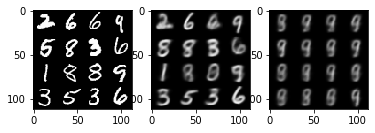

<Epoch:657/1000, Step:480/545>total_loss: 168.0714, kl_loss: 24.5793, recon_loss: 143.4921
<Epoch:658/1000, Step:435/545>total_loss: 166.2839, kl_loss: 25.7027, recon_loss: 140.5812
<Epoch:659/1000, Step:390/545>total_loss: 158.7382, kl_loss: 22.8646, recon_loss: 135.8736
<Epoch:660/1000, Step:345/545>total_loss: 166.5595, kl_loss: 25.6789, recon_loss: 140.8806
<Epoch:661/1000, Step:300/545>total_loss: 173.2033, kl_loss: 25.9519, recon_loss: 147.2513


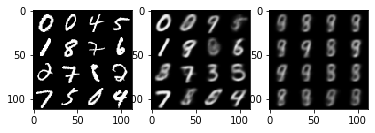

<Epoch:662/1000, Step:255/545>total_loss: 162.7104, kl_loss: 23.4490, recon_loss: 139.2614
<Epoch:663/1000, Step:210/545>total_loss: 165.5867, kl_loss: 24.1014, recon_loss: 141.4853
<Epoch:664/1000, Step:165/545>total_loss: 165.5054, kl_loss: 24.8085, recon_loss: 140.6970
<Epoch:665/1000, Step:120/545>total_loss: 162.8484, kl_loss: 24.9343, recon_loss: 137.9141
<Epoch:666/1000, Step:075/545>total_loss: 159.0534, kl_loss: 24.7157, recon_loss: 134.3377


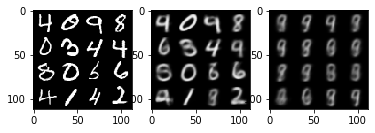

<Epoch:667/1000, Step:030/545>total_loss: 169.2408, kl_loss: 25.9984, recon_loss: 143.2423
<Epoch:667/1000, Step:530/545>total_loss: 167.2305, kl_loss: 22.8467, recon_loss: 144.3838
<Epoch:668/1000, Step:485/545>total_loss: 170.8383, kl_loss: 26.3277, recon_loss: 144.5106
<Epoch:669/1000, Step:440/545>total_loss: 160.2740, kl_loss: 23.9529, recon_loss: 136.3211
<Epoch:670/1000, Step:395/545>total_loss: 174.0991, kl_loss: 23.8457, recon_loss: 150.2533


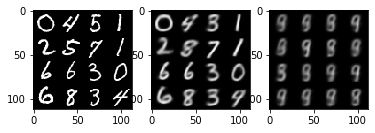

<Epoch:671/1000, Step:350/545>total_loss: 169.1432, kl_loss: 23.0280, recon_loss: 146.1152
<Epoch:672/1000, Step:305/545>total_loss: 165.2124, kl_loss: 23.2774, recon_loss: 141.9350
<Epoch:673/1000, Step:260/545>total_loss: 163.3614, kl_loss: 25.9429, recon_loss: 137.4184
<Epoch:674/1000, Step:215/545>total_loss: 168.0032, kl_loss: 26.4716, recon_loss: 141.5316
<Epoch:675/1000, Step:170/545>total_loss: 170.6349, kl_loss: 25.5705, recon_loss: 145.0643


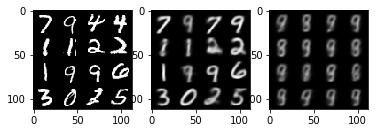

<Epoch:676/1000, Step:125/545>total_loss: 168.0405, kl_loss: 25.6060, recon_loss: 142.4345
<Epoch:677/1000, Step:080/545>total_loss: 167.4003, kl_loss: 25.7446, recon_loss: 141.6556
<Epoch:678/1000, Step:035/545>total_loss: 170.8695, kl_loss: 23.8746, recon_loss: 146.9949
<Epoch:678/1000, Step:535/545>total_loss: 174.5784, kl_loss: 26.1086, recon_loss: 148.4698
<Epoch:679/1000, Step:490/545>total_loss: 167.4522, kl_loss: 26.8705, recon_loss: 140.5817


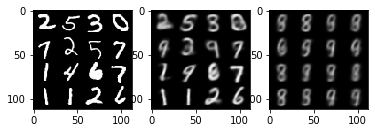

<Epoch:680/1000, Step:445/545>total_loss: 166.8297, kl_loss: 24.3470, recon_loss: 142.4827
<Epoch:681/1000, Step:400/545>total_loss: 166.3042, kl_loss: 25.6159, recon_loss: 140.6883
<Epoch:682/1000, Step:355/545>total_loss: 165.9615, kl_loss: 23.8130, recon_loss: 142.1485
<Epoch:683/1000, Step:310/545>total_loss: 157.1167, kl_loss: 23.8856, recon_loss: 133.2311
<Epoch:684/1000, Step:265/545>total_loss: 165.9252, kl_loss: 24.7763, recon_loss: 141.1489


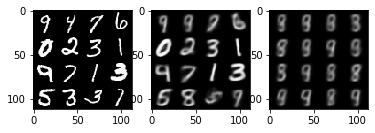

<Epoch:685/1000, Step:220/545>total_loss: 165.4280, kl_loss: 22.5780, recon_loss: 142.8500
<Epoch:686/1000, Step:175/545>total_loss: 161.6433, kl_loss: 24.8347, recon_loss: 136.8086
<Epoch:687/1000, Step:130/545>total_loss: 168.7505, kl_loss: 25.3400, recon_loss: 143.4106
<Epoch:688/1000, Step:085/545>total_loss: 168.4573, kl_loss: 24.2901, recon_loss: 144.1672
<Epoch:689/1000, Step:040/545>total_loss: 166.6530, kl_loss: 23.6444, recon_loss: 143.0086


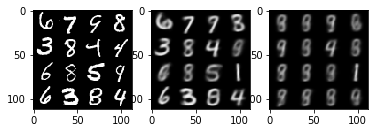

<Epoch:689/1000, Step:540/545>total_loss: 161.6042, kl_loss: 22.4891, recon_loss: 139.1151
<Epoch:690/1000, Step:495/545>total_loss: 165.8319, kl_loss: 26.0934, recon_loss: 139.7385
<Epoch:691/1000, Step:450/545>total_loss: 167.7655, kl_loss: 24.3548, recon_loss: 143.4106
<Epoch:692/1000, Step:405/545>total_loss: 163.6452, kl_loss: 23.4803, recon_loss: 140.1649
<Epoch:693/1000, Step:360/545>total_loss: 165.8753, kl_loss: 22.6775, recon_loss: 143.1979


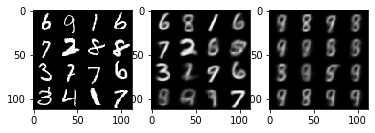

<Epoch:694/1000, Step:315/545>total_loss: 165.0313, kl_loss: 24.9416, recon_loss: 140.0897
<Epoch:695/1000, Step:270/545>total_loss: 163.0111, kl_loss: 24.4063, recon_loss: 138.6049
<Epoch:696/1000, Step:225/545>total_loss: 175.3771, kl_loss: 25.9323, recon_loss: 149.4448
<Epoch:697/1000, Step:180/545>total_loss: 164.3675, kl_loss: 24.5357, recon_loss: 139.8317
<Epoch:698/1000, Step:135/545>total_loss: 164.6283, kl_loss: 24.9653, recon_loss: 139.6630


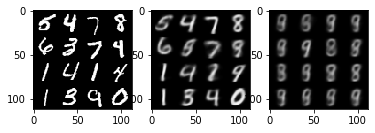

<Epoch:699/1000, Step:090/545>total_loss: 162.9689, kl_loss: 25.7043, recon_loss: 137.2645
<Epoch:700/1000, Step:045/545>total_loss: 169.4043, kl_loss: 26.0203, recon_loss: 143.3841
<Epoch:700/1000, Step:545/545>total_loss: 164.8033, kl_loss: 23.5175, recon_loss: 141.2858
<Epoch:701/1000, Step:500/545>total_loss: 158.3348, kl_loss: 24.8158, recon_loss: 133.5190
<Epoch:702/1000, Step:455/545>total_loss: 160.0610, kl_loss: 22.1893, recon_loss: 137.8717


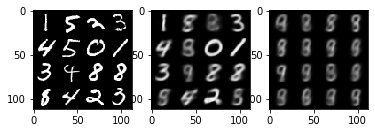

<Epoch:703/1000, Step:410/545>total_loss: 167.0043, kl_loss: 24.7156, recon_loss: 142.2887
<Epoch:704/1000, Step:365/545>total_loss: 157.2893, kl_loss: 25.4377, recon_loss: 131.8516
<Epoch:705/1000, Step:320/545>total_loss: 163.6404, kl_loss: 25.5854, recon_loss: 138.0551
<Epoch:706/1000, Step:275/545>total_loss: 170.3428, kl_loss: 25.8549, recon_loss: 144.4879
<Epoch:707/1000, Step:230/545>total_loss: 167.2999, kl_loss: 28.1874, recon_loss: 139.1125


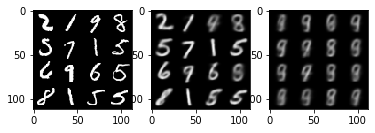

<Epoch:708/1000, Step:185/545>total_loss: 159.0238, kl_loss: 24.1498, recon_loss: 134.8740
<Epoch:709/1000, Step:140/545>total_loss: 164.2480, kl_loss: 25.2267, recon_loss: 139.0213
<Epoch:710/1000, Step:095/545>total_loss: 159.0894, kl_loss: 24.7704, recon_loss: 134.3190
<Epoch:711/1000, Step:050/545>total_loss: 168.4720, kl_loss: 27.1045, recon_loss: 141.3674
<Epoch:712/1000, Step:005/545>total_loss: 153.5769, kl_loss: 24.2278, recon_loss: 129.3491


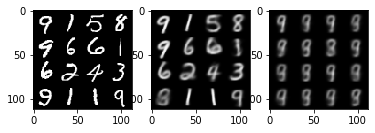

<Epoch:712/1000, Step:505/545>total_loss: 171.3847, kl_loss: 27.1574, recon_loss: 144.2273
<Epoch:713/1000, Step:460/545>total_loss: 168.4470, kl_loss: 26.3914, recon_loss: 142.0555
<Epoch:714/1000, Step:415/545>total_loss: 166.3074, kl_loss: 23.7515, recon_loss: 142.5559
<Epoch:715/1000, Step:370/545>total_loss: 169.2657, kl_loss: 27.0476, recon_loss: 142.2181
<Epoch:716/1000, Step:325/545>total_loss: 159.1990, kl_loss: 24.4514, recon_loss: 134.7477


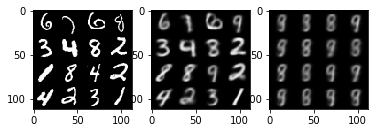

<Epoch:717/1000, Step:280/545>total_loss: 163.2474, kl_loss: 24.5886, recon_loss: 138.6589
<Epoch:718/1000, Step:235/545>total_loss: 168.8582, kl_loss: 24.7243, recon_loss: 144.1339
<Epoch:719/1000, Step:190/545>total_loss: 160.9939, kl_loss: 22.8978, recon_loss: 138.0961
<Epoch:720/1000, Step:145/545>total_loss: 166.9171, kl_loss: 23.7655, recon_loss: 143.1516
<Epoch:721/1000, Step:100/545>total_loss: 169.8090, kl_loss: 25.6435, recon_loss: 144.1655


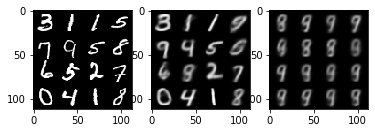

<Epoch:722/1000, Step:055/545>total_loss: 164.9440, kl_loss: 24.5895, recon_loss: 140.3545
<Epoch:723/1000, Step:010/545>total_loss: 165.2565, kl_loss: 25.2647, recon_loss: 139.9918
<Epoch:723/1000, Step:510/545>total_loss: 165.8256, kl_loss: 25.5664, recon_loss: 140.2592
<Epoch:724/1000, Step:465/545>total_loss: 161.3356, kl_loss: 22.5077, recon_loss: 138.8279
<Epoch:725/1000, Step:420/545>total_loss: 167.9729, kl_loss: 24.1584, recon_loss: 143.8145


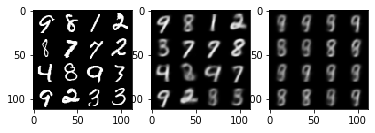

<Epoch:726/1000, Step:375/545>total_loss: 168.3083, kl_loss: 24.1728, recon_loss: 144.1356
<Epoch:727/1000, Step:330/545>total_loss: 167.0220, kl_loss: 24.3517, recon_loss: 142.6703
<Epoch:728/1000, Step:285/545>total_loss: 159.0675, kl_loss: 23.7120, recon_loss: 135.3555
<Epoch:729/1000, Step:240/545>total_loss: 171.9947, kl_loss: 25.0458, recon_loss: 146.9488
<Epoch:730/1000, Step:195/545>total_loss: 170.1421, kl_loss: 25.8089, recon_loss: 144.3331


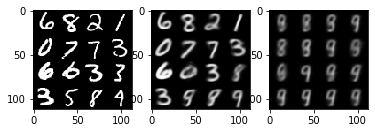

<Epoch:731/1000, Step:150/545>total_loss: 168.7500, kl_loss: 26.2748, recon_loss: 142.4752
<Epoch:732/1000, Step:105/545>total_loss: 166.0909, kl_loss: 22.6818, recon_loss: 143.4091
<Epoch:733/1000, Step:060/545>total_loss: 172.4340, kl_loss: 24.7624, recon_loss: 147.6716
<Epoch:734/1000, Step:015/545>total_loss: 168.7868, kl_loss: 26.9786, recon_loss: 141.8082
<Epoch:734/1000, Step:515/545>total_loss: 166.6336, kl_loss: 25.7259, recon_loss: 140.9077


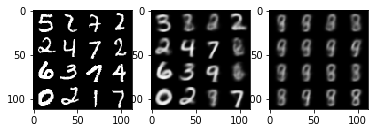

<Epoch:735/1000, Step:470/545>total_loss: 161.3374, kl_loss: 23.7311, recon_loss: 137.6063
<Epoch:736/1000, Step:425/545>total_loss: 162.3761, kl_loss: 23.4753, recon_loss: 138.9008
<Epoch:737/1000, Step:380/545>total_loss: 166.0004, kl_loss: 23.3973, recon_loss: 142.6031
<Epoch:738/1000, Step:335/545>total_loss: 163.5471, kl_loss: 25.1708, recon_loss: 138.3763
<Epoch:739/1000, Step:290/545>total_loss: 165.3344, kl_loss: 25.1352, recon_loss: 140.1993


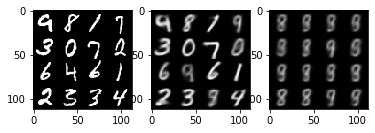

<Epoch:740/1000, Step:245/545>total_loss: 158.5205, kl_loss: 23.7325, recon_loss: 134.7880
<Epoch:741/1000, Step:200/545>total_loss: 165.1256, kl_loss: 24.4562, recon_loss: 140.6694
<Epoch:742/1000, Step:155/545>total_loss: 166.6609, kl_loss: 25.6445, recon_loss: 141.0164
<Epoch:743/1000, Step:110/545>total_loss: 169.0009, kl_loss: 25.9772, recon_loss: 143.0237
<Epoch:744/1000, Step:065/545>total_loss: 158.8506, kl_loss: 25.2540, recon_loss: 133.5966


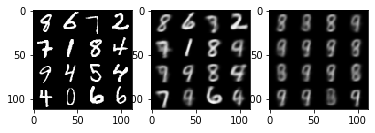

<Epoch:745/1000, Step:020/545>total_loss: 169.7671, kl_loss: 26.7486, recon_loss: 143.0185
<Epoch:745/1000, Step:520/545>total_loss: 163.9284, kl_loss: 24.1861, recon_loss: 139.7423
<Epoch:746/1000, Step:475/545>total_loss: 162.2971, kl_loss: 24.9899, recon_loss: 137.3072
<Epoch:747/1000, Step:430/545>total_loss: 170.2613, kl_loss: 25.3271, recon_loss: 144.9342
<Epoch:748/1000, Step:385/545>total_loss: 175.2233, kl_loss: 25.3166, recon_loss: 149.9067


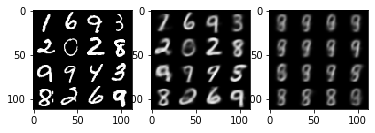

<Epoch:749/1000, Step:340/545>total_loss: 169.5107, kl_loss: 24.1681, recon_loss: 145.3425
<Epoch:750/1000, Step:295/545>total_loss: 166.8030, kl_loss: 24.7495, recon_loss: 142.0535
<Epoch:751/1000, Step:250/545>total_loss: 163.4276, kl_loss: 24.6808, recon_loss: 138.7468
<Epoch:752/1000, Step:205/545>total_loss: 172.2272, kl_loss: 25.7738, recon_loss: 146.4534
<Epoch:753/1000, Step:160/545>total_loss: 160.0254, kl_loss: 24.1924, recon_loss: 135.8330


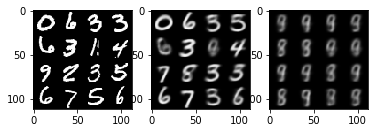

<Epoch:754/1000, Step:115/545>total_loss: 168.9985, kl_loss: 25.1655, recon_loss: 143.8330
<Epoch:755/1000, Step:070/545>total_loss: 165.5884, kl_loss: 25.3831, recon_loss: 140.2053
<Epoch:756/1000, Step:025/545>total_loss: 170.3201, kl_loss: 25.2268, recon_loss: 145.0933
<Epoch:756/1000, Step:525/545>total_loss: 169.8133, kl_loss: 24.7083, recon_loss: 145.1050
<Epoch:757/1000, Step:480/545>total_loss: 167.6735, kl_loss: 23.6835, recon_loss: 143.9900


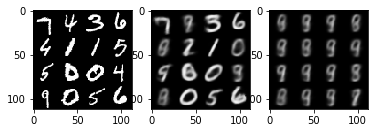

<Epoch:758/1000, Step:435/545>total_loss: 170.6295, kl_loss: 25.5046, recon_loss: 145.1249
<Epoch:759/1000, Step:390/545>total_loss: 166.1250, kl_loss: 24.0995, recon_loss: 142.0255
<Epoch:760/1000, Step:345/545>total_loss: 171.0592, kl_loss: 24.5772, recon_loss: 146.4820
<Epoch:761/1000, Step:300/545>total_loss: 169.0385, kl_loss: 25.3879, recon_loss: 143.6506
<Epoch:762/1000, Step:255/545>total_loss: 166.1671, kl_loss: 24.1094, recon_loss: 142.0577


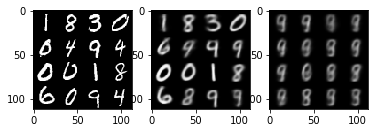

<Epoch:763/1000, Step:210/545>total_loss: 169.0022, kl_loss: 25.7781, recon_loss: 143.2240
<Epoch:764/1000, Step:165/545>total_loss: 168.0901, kl_loss: 25.5894, recon_loss: 142.5007
<Epoch:765/1000, Step:120/545>total_loss: 164.0013, kl_loss: 24.2878, recon_loss: 139.7135
<Epoch:766/1000, Step:075/545>total_loss: 167.1102, kl_loss: 24.7005, recon_loss: 142.4098
<Epoch:767/1000, Step:030/545>total_loss: 171.4207, kl_loss: 26.5928, recon_loss: 144.8279


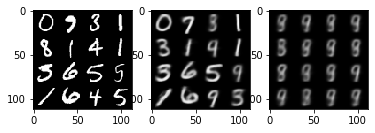

<Epoch:767/1000, Step:530/545>total_loss: 170.7053, kl_loss: 25.8270, recon_loss: 144.8783
<Epoch:768/1000, Step:485/545>total_loss: 164.8765, kl_loss: 23.1948, recon_loss: 141.6817
<Epoch:769/1000, Step:440/545>total_loss: 164.0691, kl_loss: 24.5336, recon_loss: 139.5355
<Epoch:770/1000, Step:395/545>total_loss: 173.1108, kl_loss: 28.6681, recon_loss: 144.4427
<Epoch:771/1000, Step:350/545>total_loss: 170.3065, kl_loss: 23.1313, recon_loss: 147.1751


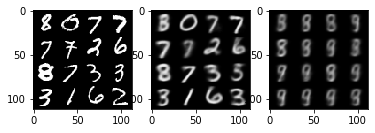

<Epoch:772/1000, Step:305/545>total_loss: 163.0606, kl_loss: 25.6480, recon_loss: 137.4125
<Epoch:773/1000, Step:260/545>total_loss: 170.1306, kl_loss: 26.3578, recon_loss: 143.7729
<Epoch:774/1000, Step:215/545>total_loss: 165.9324, kl_loss: 23.8311, recon_loss: 142.1014
<Epoch:775/1000, Step:170/545>total_loss: 164.3953, kl_loss: 22.9619, recon_loss: 141.4333
<Epoch:776/1000, Step:125/545>total_loss: 168.5121, kl_loss: 25.3779, recon_loss: 143.1343


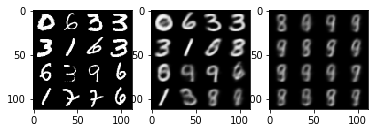

<Epoch:777/1000, Step:080/545>total_loss: 167.6965, kl_loss: 24.4833, recon_loss: 143.2131
<Epoch:778/1000, Step:035/545>total_loss: 164.0572, kl_loss: 24.9533, recon_loss: 139.1039
<Epoch:778/1000, Step:535/545>total_loss: 162.4204, kl_loss: 26.2933, recon_loss: 136.1271
<Epoch:779/1000, Step:490/545>total_loss: 168.7510, kl_loss: 23.8664, recon_loss: 144.8846
<Epoch:780/1000, Step:445/545>total_loss: 170.1959, kl_loss: 24.1966, recon_loss: 145.9993


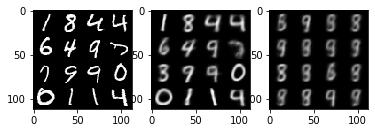

<Epoch:781/1000, Step:400/545>total_loss: 163.8561, kl_loss: 25.9431, recon_loss: 137.9129
<Epoch:782/1000, Step:355/545>total_loss: 163.6645, kl_loss: 24.1324, recon_loss: 139.5321
<Epoch:783/1000, Step:310/545>total_loss: 153.2030, kl_loss: 21.4939, recon_loss: 131.7092
<Epoch:784/1000, Step:265/545>total_loss: 165.6989, kl_loss: 26.3743, recon_loss: 139.3246
<Epoch:785/1000, Step:220/545>total_loss: 165.9895, kl_loss: 26.2021, recon_loss: 139.7873


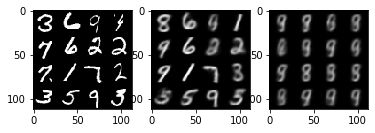

<Epoch:786/1000, Step:175/545>total_loss: 164.1566, kl_loss: 22.4807, recon_loss: 141.6759
<Epoch:787/1000, Step:130/545>total_loss: 164.9794, kl_loss: 25.9942, recon_loss: 138.9852
<Epoch:788/1000, Step:085/545>total_loss: 169.5232, kl_loss: 25.0396, recon_loss: 144.4836
<Epoch:789/1000, Step:040/545>total_loss: 165.5968, kl_loss: 25.1407, recon_loss: 140.4561
<Epoch:789/1000, Step:540/545>total_loss: 161.8562, kl_loss: 24.8267, recon_loss: 137.0295


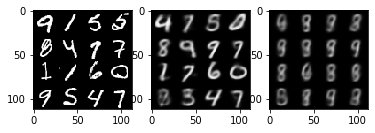

<Epoch:790/1000, Step:495/545>total_loss: 168.7840, kl_loss: 25.5662, recon_loss: 143.2178
<Epoch:791/1000, Step:450/545>total_loss: 171.3020, kl_loss: 26.4192, recon_loss: 144.8828
<Epoch:792/1000, Step:405/545>total_loss: 163.2132, kl_loss: 24.5006, recon_loss: 138.7126
<Epoch:793/1000, Step:360/545>total_loss: 169.6832, kl_loss: 25.9543, recon_loss: 143.7289
<Epoch:794/1000, Step:315/545>total_loss: 162.2137, kl_loss: 23.1430, recon_loss: 139.0707


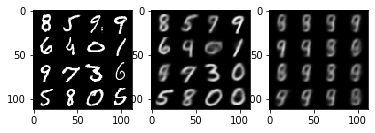

<Epoch:795/1000, Step:270/545>total_loss: 163.6994, kl_loss: 25.2230, recon_loss: 138.4764
<Epoch:796/1000, Step:225/545>total_loss: 161.4711, kl_loss: 24.5276, recon_loss: 136.9435
<Epoch:797/1000, Step:180/545>total_loss: 167.0414, kl_loss: 25.5124, recon_loss: 141.5290
<Epoch:798/1000, Step:135/545>total_loss: 161.9748, kl_loss: 23.6546, recon_loss: 138.3202
<Epoch:799/1000, Step:090/545>total_loss: 162.3529, kl_loss: 23.5850, recon_loss: 138.7680


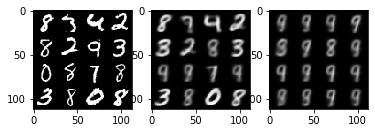

<Epoch:800/1000, Step:045/545>total_loss: 167.4104, kl_loss: 24.1563, recon_loss: 143.2541
<Epoch:800/1000, Step:545/545>total_loss: 160.6177, kl_loss: 25.4771, recon_loss: 135.1407
<Epoch:801/1000, Step:500/545>total_loss: 166.4495, kl_loss: 25.5931, recon_loss: 140.8563
<Epoch:802/1000, Step:455/545>total_loss: 171.4200, kl_loss: 24.9399, recon_loss: 146.4800
<Epoch:803/1000, Step:410/545>total_loss: 172.8978, kl_loss: 27.3360, recon_loss: 145.5619


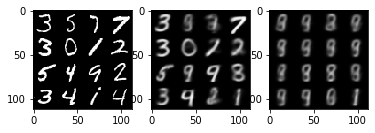

<Epoch:804/1000, Step:365/545>total_loss: 165.7525, kl_loss: 24.7491, recon_loss: 141.0034
<Epoch:805/1000, Step:320/545>total_loss: 162.3918, kl_loss: 24.7395, recon_loss: 137.6523
<Epoch:806/1000, Step:275/545>total_loss: 170.4070, kl_loss: 25.0473, recon_loss: 145.3598
<Epoch:807/1000, Step:230/545>total_loss: 169.2785, kl_loss: 26.0833, recon_loss: 143.1953
<Epoch:808/1000, Step:185/545>total_loss: 168.9811, kl_loss: 26.9286, recon_loss: 142.0525


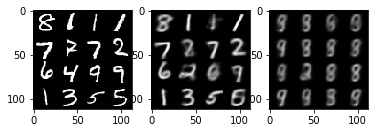

<Epoch:809/1000, Step:140/545>total_loss: 165.7786, kl_loss: 24.8669, recon_loss: 140.9117
<Epoch:810/1000, Step:095/545>total_loss: 166.6864, kl_loss: 24.0226, recon_loss: 142.6638
<Epoch:811/1000, Step:050/545>total_loss: 169.2139, kl_loss: 25.3861, recon_loss: 143.8278
<Epoch:812/1000, Step:005/545>total_loss: 160.5630, kl_loss: 25.0148, recon_loss: 135.5481
<Epoch:812/1000, Step:505/545>total_loss: 170.0880, kl_loss: 26.1420, recon_loss: 143.9460


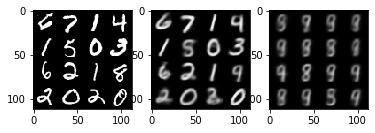

<Epoch:813/1000, Step:460/545>total_loss: 168.6559, kl_loss: 26.1174, recon_loss: 142.5385
<Epoch:814/1000, Step:415/545>total_loss: 163.8430, kl_loss: 25.0638, recon_loss: 138.7792
<Epoch:815/1000, Step:370/545>total_loss: 174.1552, kl_loss: 27.3054, recon_loss: 146.8498
<Epoch:816/1000, Step:325/545>total_loss: 167.1408, kl_loss: 26.6938, recon_loss: 140.4470
<Epoch:817/1000, Step:280/545>total_loss: 167.4114, kl_loss: 24.2396, recon_loss: 143.1718


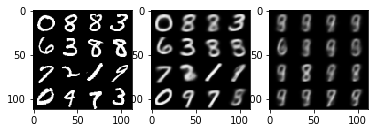

<Epoch:818/1000, Step:235/545>total_loss: 159.1585, kl_loss: 24.1302, recon_loss: 135.0283
<Epoch:819/1000, Step:190/545>total_loss: 154.5250, kl_loss: 24.9798, recon_loss: 129.5453
<Epoch:820/1000, Step:145/545>total_loss: 169.5519, kl_loss: 24.6900, recon_loss: 144.8619
<Epoch:821/1000, Step:100/545>total_loss: 159.5688, kl_loss: 25.0266, recon_loss: 134.5422
<Epoch:822/1000, Step:055/545>total_loss: 163.1118, kl_loss: 25.8978, recon_loss: 137.2141


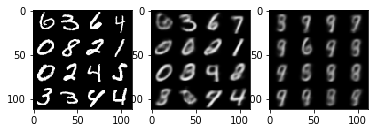

<Epoch:823/1000, Step:010/545>total_loss: 167.7183, kl_loss: 25.7195, recon_loss: 141.9987
<Epoch:823/1000, Step:510/545>total_loss: 173.3165, kl_loss: 24.6208, recon_loss: 148.6957
<Epoch:824/1000, Step:465/545>total_loss: 168.8111, kl_loss: 24.4138, recon_loss: 144.3973
<Epoch:825/1000, Step:420/545>total_loss: 163.5675, kl_loss: 24.2513, recon_loss: 139.3162
<Epoch:826/1000, Step:375/545>total_loss: 165.2386, kl_loss: 26.4235, recon_loss: 138.8151


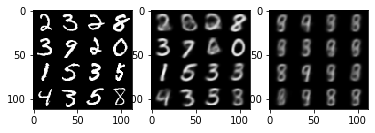

<Epoch:827/1000, Step:330/545>total_loss: 164.0273, kl_loss: 23.6784, recon_loss: 140.3488
<Epoch:828/1000, Step:285/545>total_loss: 162.2661, kl_loss: 24.3446, recon_loss: 137.9215
<Epoch:829/1000, Step:240/545>total_loss: 161.7145, kl_loss: 26.5737, recon_loss: 135.1408
<Epoch:830/1000, Step:195/545>total_loss: 158.1369, kl_loss: 24.4945, recon_loss: 133.6424
<Epoch:831/1000, Step:150/545>total_loss: 165.2925, kl_loss: 24.3140, recon_loss: 140.9785


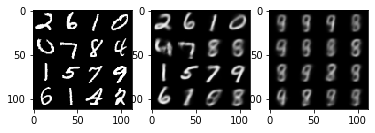

<Epoch:832/1000, Step:105/545>total_loss: 171.3245, kl_loss: 26.5511, recon_loss: 144.7735
<Epoch:833/1000, Step:060/545>total_loss: 165.6540, kl_loss: 24.9890, recon_loss: 140.6650
<Epoch:834/1000, Step:015/545>total_loss: 165.8170, kl_loss: 23.8733, recon_loss: 141.9437
<Epoch:834/1000, Step:515/545>total_loss: 165.1566, kl_loss: 24.7076, recon_loss: 140.4489
<Epoch:835/1000, Step:470/545>total_loss: 174.7748, kl_loss: 27.1444, recon_loss: 147.6304


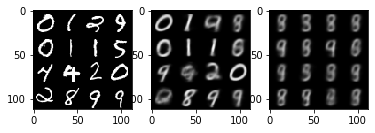

<Epoch:836/1000, Step:425/545>total_loss: 163.9120, kl_loss: 25.3338, recon_loss: 138.5782
<Epoch:837/1000, Step:380/545>total_loss: 169.8430, kl_loss: 24.7632, recon_loss: 145.0798
<Epoch:838/1000, Step:335/545>total_loss: 169.6035, kl_loss: 25.2035, recon_loss: 144.3999
<Epoch:839/1000, Step:290/545>total_loss: 162.7009, kl_loss: 23.9937, recon_loss: 138.7072
<Epoch:840/1000, Step:245/545>total_loss: 163.5249, kl_loss: 24.8192, recon_loss: 138.7057


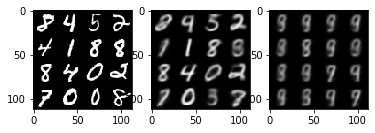

<Epoch:841/1000, Step:200/545>total_loss: 163.7541, kl_loss: 25.3054, recon_loss: 138.4487
<Epoch:842/1000, Step:155/545>total_loss: 168.0308, kl_loss: 25.4040, recon_loss: 142.6268
<Epoch:843/1000, Step:110/545>total_loss: 163.0448, kl_loss: 24.6293, recon_loss: 138.4155
<Epoch:844/1000, Step:065/545>total_loss: 166.8320, kl_loss: 24.2031, recon_loss: 142.6289
<Epoch:845/1000, Step:020/545>total_loss: 166.2021, kl_loss: 25.5572, recon_loss: 140.6449


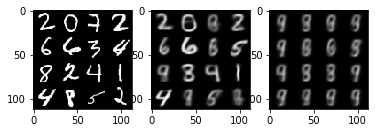

<Epoch:845/1000, Step:520/545>total_loss: 168.8521, kl_loss: 26.7674, recon_loss: 142.0847
<Epoch:846/1000, Step:475/545>total_loss: 166.3415, kl_loss: 23.4282, recon_loss: 142.9132
<Epoch:847/1000, Step:430/545>total_loss: 169.1999, kl_loss: 26.1638, recon_loss: 143.0361
<Epoch:848/1000, Step:385/545>total_loss: 160.5944, kl_loss: 23.7441, recon_loss: 136.8503
<Epoch:849/1000, Step:340/545>total_loss: 170.3588, kl_loss: 27.5107, recon_loss: 142.8480


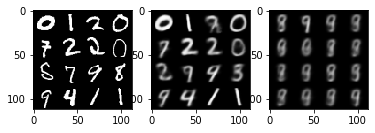

<Epoch:850/1000, Step:295/545>total_loss: 163.4240, kl_loss: 25.2935, recon_loss: 138.1305
<Epoch:851/1000, Step:250/545>total_loss: 167.9066, kl_loss: 24.3032, recon_loss: 143.6034
<Epoch:852/1000, Step:205/545>total_loss: 163.7611, kl_loss: 24.1384, recon_loss: 139.6227
<Epoch:853/1000, Step:160/545>total_loss: 167.6544, kl_loss: 24.0702, recon_loss: 143.5842
<Epoch:854/1000, Step:115/545>total_loss: 161.2946, kl_loss: 24.2355, recon_loss: 137.0591


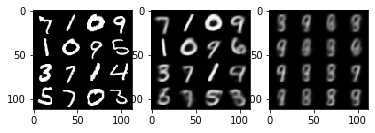

<Epoch:855/1000, Step:070/545>total_loss: 164.7546, kl_loss: 23.8197, recon_loss: 140.9349
<Epoch:856/1000, Step:025/545>total_loss: 166.3002, kl_loss: 25.0040, recon_loss: 141.2962
<Epoch:856/1000, Step:525/545>total_loss: 164.4375, kl_loss: 23.2329, recon_loss: 141.2045
<Epoch:857/1000, Step:480/545>total_loss: 161.9028, kl_loss: 26.0343, recon_loss: 135.8686
<Epoch:858/1000, Step:435/545>total_loss: 169.0679, kl_loss: 27.3707, recon_loss: 141.6972


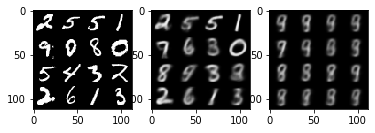

<Epoch:859/1000, Step:390/545>total_loss: 171.6395, kl_loss: 27.0099, recon_loss: 144.6296
<Epoch:860/1000, Step:345/545>total_loss: 168.4018, kl_loss: 24.8755, recon_loss: 143.5263
<Epoch:861/1000, Step:300/545>total_loss: 168.6213, kl_loss: 25.5665, recon_loss: 143.0548
<Epoch:862/1000, Step:255/545>total_loss: 164.7568, kl_loss: 26.2715, recon_loss: 138.4852
<Epoch:863/1000, Step:210/545>total_loss: 166.0771, kl_loss: 26.1305, recon_loss: 139.9466


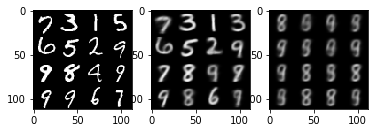

<Epoch:864/1000, Step:165/545>total_loss: 163.9088, kl_loss: 26.9349, recon_loss: 136.9740
<Epoch:865/1000, Step:120/545>total_loss: 168.0897, kl_loss: 24.6133, recon_loss: 143.4764
<Epoch:866/1000, Step:075/545>total_loss: 170.0083, kl_loss: 25.8139, recon_loss: 144.1944
<Epoch:867/1000, Step:030/545>total_loss: 163.4975, kl_loss: 26.7397, recon_loss: 136.7578
<Epoch:867/1000, Step:530/545>total_loss: 164.9937, kl_loss: 23.8861, recon_loss: 141.1075


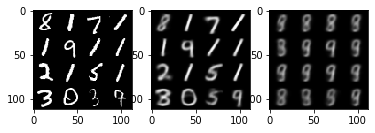

<Epoch:868/1000, Step:485/545>total_loss: 155.4765, kl_loss: 22.6780, recon_loss: 132.7985
<Epoch:869/1000, Step:440/545>total_loss: 156.0734, kl_loss: 22.7629, recon_loss: 133.3105
<Epoch:870/1000, Step:395/545>total_loss: 168.2038, kl_loss: 23.8813, recon_loss: 144.3224
<Epoch:871/1000, Step:350/545>total_loss: 171.6393, kl_loss: 26.1907, recon_loss: 145.4485
<Epoch:872/1000, Step:305/545>total_loss: 168.7200, kl_loss: 26.7573, recon_loss: 141.9628


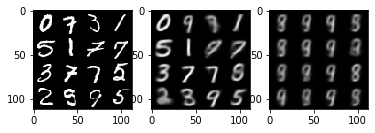

<Epoch:873/1000, Step:260/545>total_loss: 156.6894, kl_loss: 24.5821, recon_loss: 132.1073
<Epoch:874/1000, Step:215/545>total_loss: 164.6713, kl_loss: 24.3010, recon_loss: 140.3703
<Epoch:875/1000, Step:170/545>total_loss: 164.3087, kl_loss: 26.9429, recon_loss: 137.3658
<Epoch:876/1000, Step:125/545>total_loss: 165.9339, kl_loss: 24.4581, recon_loss: 141.4758
<Epoch:877/1000, Step:080/545>total_loss: 165.7777, kl_loss: 25.5805, recon_loss: 140.1971


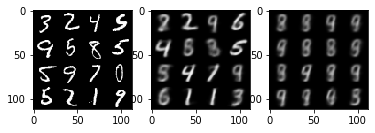

<Epoch:878/1000, Step:035/545>total_loss: 169.2953, kl_loss: 24.5497, recon_loss: 144.7456
<Epoch:878/1000, Step:535/545>total_loss: 165.1645, kl_loss: 24.1276, recon_loss: 141.0369
<Epoch:879/1000, Step:490/545>total_loss: 168.8151, kl_loss: 24.8847, recon_loss: 143.9305
<Epoch:880/1000, Step:445/545>total_loss: 166.2537, kl_loss: 25.8287, recon_loss: 140.4250
<Epoch:881/1000, Step:400/545>total_loss: 165.9963, kl_loss: 25.1188, recon_loss: 140.8775


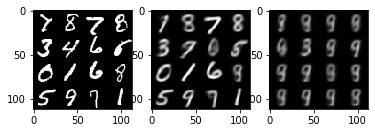

<Epoch:882/1000, Step:355/545>total_loss: 168.6123, kl_loss: 23.9806, recon_loss: 144.6317
<Epoch:883/1000, Step:310/545>total_loss: 172.2526, kl_loss: 26.9267, recon_loss: 145.3259
<Epoch:884/1000, Step:265/545>total_loss: 158.2920, kl_loss: 23.5199, recon_loss: 134.7721
<Epoch:885/1000, Step:220/545>total_loss: 163.6398, kl_loss: 25.8181, recon_loss: 137.8217
<Epoch:886/1000, Step:175/545>total_loss: 163.2396, kl_loss: 25.3426, recon_loss: 137.8970


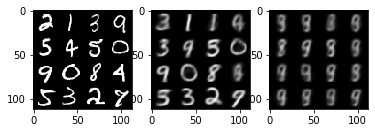

<Epoch:887/1000, Step:130/545>total_loss: 162.6423, kl_loss: 25.0691, recon_loss: 137.5731
<Epoch:888/1000, Step:085/545>total_loss: 171.6385, kl_loss: 25.0062, recon_loss: 146.6323
<Epoch:889/1000, Step:040/545>total_loss: 168.2399, kl_loss: 25.0969, recon_loss: 143.1430
<Epoch:889/1000, Step:540/545>total_loss: 162.9876, kl_loss: 22.5139, recon_loss: 140.4737
<Epoch:890/1000, Step:495/545>total_loss: 170.7602, kl_loss: 25.6889, recon_loss: 145.0713


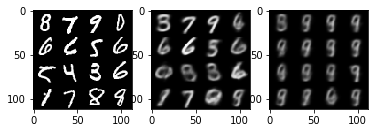

<Epoch:891/1000, Step:450/545>total_loss: 166.4095, kl_loss: 23.2925, recon_loss: 143.1170
<Epoch:892/1000, Step:405/545>total_loss: 162.3542, kl_loss: 24.2781, recon_loss: 138.0760
<Epoch:893/1000, Step:360/545>total_loss: 165.2203, kl_loss: 26.5857, recon_loss: 138.6347
<Epoch:894/1000, Step:315/545>total_loss: 167.2426, kl_loss: 25.4163, recon_loss: 141.8264
<Epoch:895/1000, Step:270/545>total_loss: 167.2774, kl_loss: 23.7569, recon_loss: 143.5205


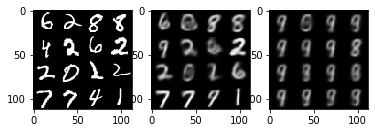

<Epoch:896/1000, Step:225/545>total_loss: 163.6447, kl_loss: 25.8984, recon_loss: 137.7463
<Epoch:897/1000, Step:180/545>total_loss: 164.8844, kl_loss: 24.8598, recon_loss: 140.0246
<Epoch:898/1000, Step:135/545>total_loss: 165.8373, kl_loss: 22.6189, recon_loss: 143.2184
<Epoch:899/1000, Step:090/545>total_loss: 166.2484, kl_loss: 24.5748, recon_loss: 141.6737
<Epoch:900/1000, Step:045/545>total_loss: 171.8816, kl_loss: 25.4156, recon_loss: 146.4660


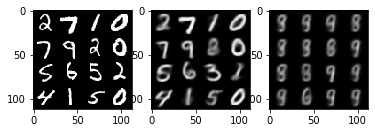

<Epoch:900/1000, Step:545/545>total_loss: 162.4942, kl_loss: 23.8230, recon_loss: 138.6712
<Epoch:901/1000, Step:500/545>total_loss: 155.4544, kl_loss: 23.7677, recon_loss: 131.6867
<Epoch:902/1000, Step:455/545>total_loss: 173.3039, kl_loss: 28.0103, recon_loss: 145.2937
<Epoch:903/1000, Step:410/545>total_loss: 160.0912, kl_loss: 24.1997, recon_loss: 135.8916
<Epoch:904/1000, Step:365/545>total_loss: 169.7969, kl_loss: 26.4287, recon_loss: 143.3682


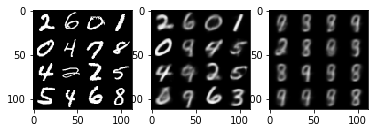

<Epoch:905/1000, Step:320/545>total_loss: 166.6791, kl_loss: 24.4001, recon_loss: 142.2790
<Epoch:906/1000, Step:275/545>total_loss: 160.6769, kl_loss: 25.4005, recon_loss: 135.2764
<Epoch:907/1000, Step:230/545>total_loss: 174.3935, kl_loss: 26.6033, recon_loss: 147.7901
<Epoch:908/1000, Step:185/545>total_loss: 162.2337, kl_loss: 23.4079, recon_loss: 138.8258
<Epoch:909/1000, Step:140/545>total_loss: 163.4496, kl_loss: 24.4723, recon_loss: 138.9773


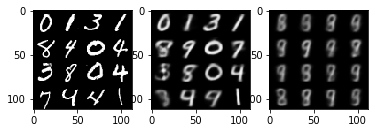

<Epoch:910/1000, Step:095/545>total_loss: 169.1124, kl_loss: 25.1678, recon_loss: 143.9445
<Epoch:911/1000, Step:050/545>total_loss: 171.6914, kl_loss: 25.0038, recon_loss: 146.6876
<Epoch:912/1000, Step:005/545>total_loss: 170.1432, kl_loss: 27.0484, recon_loss: 143.0947
<Epoch:912/1000, Step:505/545>total_loss: 160.0018, kl_loss: 26.0143, recon_loss: 133.9875
<Epoch:913/1000, Step:460/545>total_loss: 160.8826, kl_loss: 24.3696, recon_loss: 136.5130


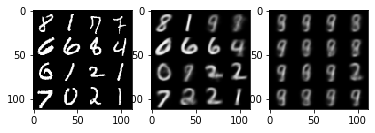

<Epoch:914/1000, Step:415/545>total_loss: 163.8867, kl_loss: 26.2072, recon_loss: 137.6795
<Epoch:915/1000, Step:370/545>total_loss: 171.4234, kl_loss: 27.5894, recon_loss: 143.8339
<Epoch:916/1000, Step:325/545>total_loss: 162.9811, kl_loss: 25.8691, recon_loss: 137.1120
<Epoch:917/1000, Step:280/545>total_loss: 166.1812, kl_loss: 23.6699, recon_loss: 142.5114
<Epoch:918/1000, Step:235/545>total_loss: 161.4878, kl_loss: 24.6932, recon_loss: 136.7946


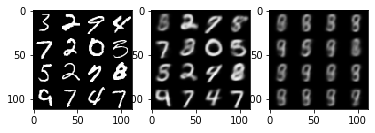

<Epoch:919/1000, Step:190/545>total_loss: 168.4364, kl_loss: 23.3397, recon_loss: 145.0967
<Epoch:920/1000, Step:145/545>total_loss: 159.7474, kl_loss: 24.3051, recon_loss: 135.4423
<Epoch:921/1000, Step:100/545>total_loss: 172.3016, kl_loss: 24.5995, recon_loss: 147.7021
<Epoch:922/1000, Step:055/545>total_loss: 166.5566, kl_loss: 23.8236, recon_loss: 142.7330
<Epoch:923/1000, Step:010/545>total_loss: 168.8051, kl_loss: 25.5282, recon_loss: 143.2770


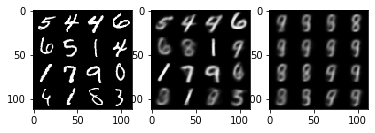

<Epoch:923/1000, Step:510/545>total_loss: 168.8058, kl_loss: 27.0998, recon_loss: 141.7060
<Epoch:924/1000, Step:465/545>total_loss: 166.1573, kl_loss: 28.4055, recon_loss: 137.7518
<Epoch:925/1000, Step:420/545>total_loss: 169.5172, kl_loss: 26.9760, recon_loss: 142.5412
<Epoch:926/1000, Step:375/545>total_loss: 163.7055, kl_loss: 25.1313, recon_loss: 138.5742
<Epoch:927/1000, Step:330/545>total_loss: 166.2726, kl_loss: 24.1771, recon_loss: 142.0955


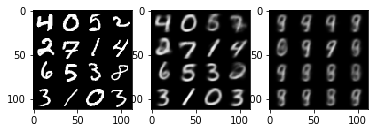

<Epoch:928/1000, Step:285/545>total_loss: 162.2266, kl_loss: 24.0679, recon_loss: 138.1587
<Epoch:929/1000, Step:240/545>total_loss: 166.8654, kl_loss: 24.6322, recon_loss: 142.2332
<Epoch:930/1000, Step:195/545>total_loss: 162.5352, kl_loss: 23.7402, recon_loss: 138.7951
<Epoch:931/1000, Step:150/545>total_loss: 160.2381, kl_loss: 24.0662, recon_loss: 136.1718
<Epoch:932/1000, Step:105/545>total_loss: 168.7105, kl_loss: 24.6745, recon_loss: 144.0360


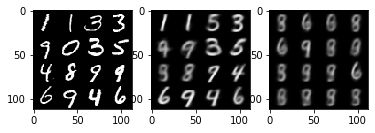

<Epoch:933/1000, Step:060/545>total_loss: 167.5656, kl_loss: 26.4898, recon_loss: 141.0758
<Epoch:934/1000, Step:015/545>total_loss: 164.5262, kl_loss: 26.5743, recon_loss: 137.9518
<Epoch:934/1000, Step:515/545>total_loss: 165.3629, kl_loss: 24.3131, recon_loss: 141.0498
<Epoch:935/1000, Step:470/545>total_loss: 172.4932, kl_loss: 24.5582, recon_loss: 147.9349
<Epoch:936/1000, Step:425/545>total_loss: 160.2491, kl_loss: 24.7209, recon_loss: 135.5282


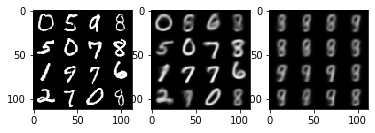

<Epoch:937/1000, Step:380/545>total_loss: 165.3429, kl_loss: 25.0934, recon_loss: 140.2495
<Epoch:938/1000, Step:335/545>total_loss: 165.6994, kl_loss: 24.4884, recon_loss: 141.2110
<Epoch:939/1000, Step:290/545>total_loss: 169.1582, kl_loss: 25.8988, recon_loss: 143.2595
<Epoch:940/1000, Step:245/545>total_loss: 164.4510, kl_loss: 26.4543, recon_loss: 137.9967
<Epoch:941/1000, Step:200/545>total_loss: 165.5180, kl_loss: 25.0779, recon_loss: 140.4401


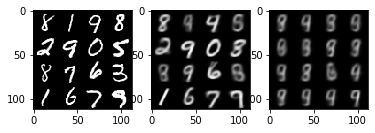

<Epoch:942/1000, Step:155/545>total_loss: 167.4557, kl_loss: 25.6240, recon_loss: 141.8316
<Epoch:943/1000, Step:110/545>total_loss: 166.8997, kl_loss: 26.8519, recon_loss: 140.0478
<Epoch:944/1000, Step:065/545>total_loss: 165.3091, kl_loss: 24.4859, recon_loss: 140.8232
<Epoch:945/1000, Step:020/545>total_loss: 167.0240, kl_loss: 23.6168, recon_loss: 143.4071
<Epoch:945/1000, Step:520/545>total_loss: 158.7482, kl_loss: 25.7211, recon_loss: 133.0271


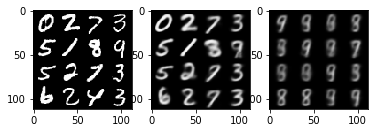

<Epoch:946/1000, Step:475/545>total_loss: 161.7780, kl_loss: 23.9601, recon_loss: 137.8178
<Epoch:947/1000, Step:430/545>total_loss: 163.9951, kl_loss: 23.0743, recon_loss: 140.9208
<Epoch:948/1000, Step:385/545>total_loss: 159.6393, kl_loss: 24.5207, recon_loss: 135.1186
<Epoch:949/1000, Step:340/545>total_loss: 165.8953, kl_loss: 24.0960, recon_loss: 141.7994
<Epoch:950/1000, Step:295/545>total_loss: 160.3402, kl_loss: 24.5039, recon_loss: 135.8363


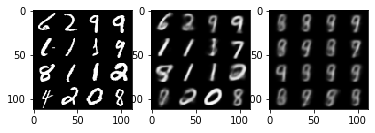

<Epoch:951/1000, Step:250/545>total_loss: 171.3624, kl_loss: 24.3114, recon_loss: 147.0510
<Epoch:952/1000, Step:205/545>total_loss: 166.9638, kl_loss: 26.3062, recon_loss: 140.6577
<Epoch:953/1000, Step:160/545>total_loss: 164.4043, kl_loss: 23.5354, recon_loss: 140.8689
<Epoch:954/1000, Step:115/545>total_loss: 163.5118, kl_loss: 24.3813, recon_loss: 139.1305
<Epoch:955/1000, Step:070/545>total_loss: 162.3553, kl_loss: 23.1982, recon_loss: 139.1571


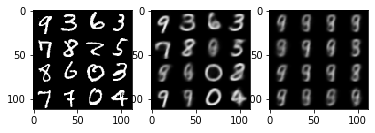

<Epoch:956/1000, Step:025/545>total_loss: 163.5455, kl_loss: 25.1804, recon_loss: 138.3651
<Epoch:956/1000, Step:525/545>total_loss: 164.7773, kl_loss: 22.9271, recon_loss: 141.8502
<Epoch:957/1000, Step:480/545>total_loss: 167.1180, kl_loss: 25.0961, recon_loss: 142.0219
<Epoch:958/1000, Step:435/545>total_loss: 162.0970, kl_loss: 22.5333, recon_loss: 139.5637
<Epoch:959/1000, Step:390/545>total_loss: 174.4296, kl_loss: 26.3764, recon_loss: 148.0531


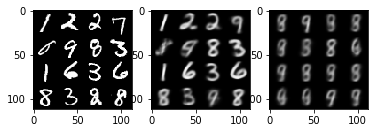

<Epoch:960/1000, Step:345/545>total_loss: 163.8025, kl_loss: 26.5847, recon_loss: 137.2178
<Epoch:961/1000, Step:300/545>total_loss: 173.0238, kl_loss: 24.9112, recon_loss: 148.1126
<Epoch:962/1000, Step:255/545>total_loss: 162.1024, kl_loss: 26.1111, recon_loss: 135.9912
<Epoch:963/1000, Step:210/545>total_loss: 164.4635, kl_loss: 24.8891, recon_loss: 139.5744
<Epoch:964/1000, Step:165/545>total_loss: 165.2657, kl_loss: 25.0497, recon_loss: 140.2160


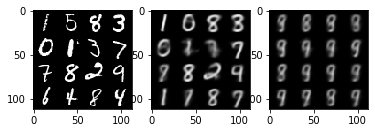

<Epoch:965/1000, Step:120/545>total_loss: 162.4825, kl_loss: 25.4298, recon_loss: 137.0526
<Epoch:966/1000, Step:075/545>total_loss: 172.6499, kl_loss: 24.7108, recon_loss: 147.9391
<Epoch:967/1000, Step:030/545>total_loss: 167.1483, kl_loss: 25.4503, recon_loss: 141.6980
<Epoch:967/1000, Step:530/545>total_loss: 166.1950, kl_loss: 25.4085, recon_loss: 140.7866
<Epoch:968/1000, Step:485/545>total_loss: 176.4455, kl_loss: 25.5899, recon_loss: 150.8556


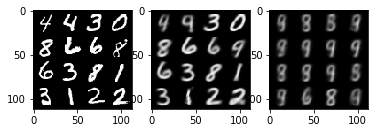

<Epoch:969/1000, Step:440/545>total_loss: 168.6406, kl_loss: 28.0572, recon_loss: 140.5834
<Epoch:970/1000, Step:395/545>total_loss: 166.3030, kl_loss: 26.7063, recon_loss: 139.5968
<Epoch:971/1000, Step:350/545>total_loss: 167.2463, kl_loss: 25.8152, recon_loss: 141.4311
<Epoch:972/1000, Step:305/545>total_loss: 170.1601, kl_loss: 25.9071, recon_loss: 144.2529
<Epoch:973/1000, Step:260/545>total_loss: 163.8833, kl_loss: 25.1072, recon_loss: 138.7761


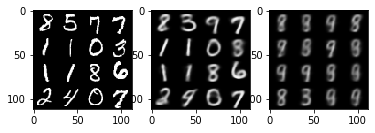

<Epoch:974/1000, Step:215/545>total_loss: 159.0067, kl_loss: 26.8711, recon_loss: 132.1356
<Epoch:975/1000, Step:170/545>total_loss: 165.7717, kl_loss: 24.0102, recon_loss: 141.7615
<Epoch:976/1000, Step:125/545>total_loss: 171.6277, kl_loss: 25.5728, recon_loss: 146.0548
<Epoch:977/1000, Step:080/545>total_loss: 160.5158, kl_loss: 24.7127, recon_loss: 135.8031
<Epoch:978/1000, Step:035/545>total_loss: 171.9350, kl_loss: 25.0124, recon_loss: 146.9226


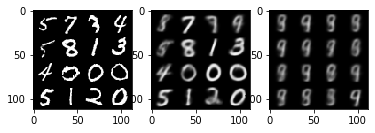

<Epoch:978/1000, Step:535/545>total_loss: 162.5829, kl_loss: 24.0061, recon_loss: 138.5769
<Epoch:979/1000, Step:490/545>total_loss: 165.7105, kl_loss: 26.6716, recon_loss: 139.0388
<Epoch:980/1000, Step:445/545>total_loss: 162.4600, kl_loss: 24.7372, recon_loss: 137.7227
<Epoch:981/1000, Step:400/545>total_loss: 166.7068, kl_loss: 25.3107, recon_loss: 141.3961
<Epoch:982/1000, Step:355/545>total_loss: 164.3418, kl_loss: 24.8606, recon_loss: 139.4812


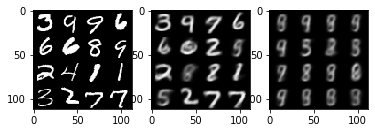

<Epoch:983/1000, Step:310/545>total_loss: 168.3501, kl_loss: 25.8055, recon_loss: 142.5446
<Epoch:984/1000, Step:265/545>total_loss: 171.7866, kl_loss: 25.3340, recon_loss: 146.4525
<Epoch:985/1000, Step:220/545>total_loss: 171.7065, kl_loss: 25.1803, recon_loss: 146.5262
<Epoch:986/1000, Step:175/545>total_loss: 164.3966, kl_loss: 25.7463, recon_loss: 138.6503
<Epoch:987/1000, Step:130/545>total_loss: 165.7300, kl_loss: 26.3037, recon_loss: 139.4263


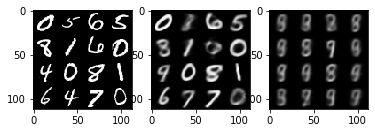

<Epoch:988/1000, Step:085/545>total_loss: 162.9760, kl_loss: 21.8515, recon_loss: 141.1245
<Epoch:989/1000, Step:040/545>total_loss: 169.8848, kl_loss: 23.3676, recon_loss: 146.5171
<Epoch:989/1000, Step:540/545>total_loss: 168.5068, kl_loss: 26.6097, recon_loss: 141.8971
<Epoch:990/1000, Step:495/545>total_loss: 175.8011, kl_loss: 24.9718, recon_loss: 150.8293
<Epoch:991/1000, Step:450/545>total_loss: 168.5908, kl_loss: 24.9223, recon_loss: 143.6685


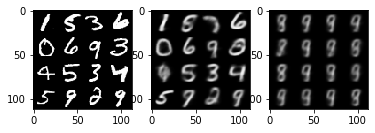

<Epoch:992/1000, Step:405/545>total_loss: 166.3330, kl_loss: 26.2695, recon_loss: 140.0635
<Epoch:993/1000, Step:360/545>total_loss: 169.7811, kl_loss: 26.1162, recon_loss: 143.6649
<Epoch:994/1000, Step:315/545>total_loss: 169.1635, kl_loss: 25.3205, recon_loss: 143.8430
<Epoch:995/1000, Step:270/545>total_loss: 164.6003, kl_loss: 25.4718, recon_loss: 139.1285
<Epoch:996/1000, Step:225/545>total_loss: 168.5884, kl_loss: 25.0891, recon_loss: 143.4993


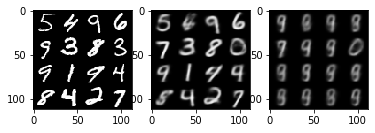

<Epoch:997/1000, Step:180/545>total_loss: 167.5559, kl_loss: 26.6463, recon_loss: 140.9097
<Epoch:998/1000, Step:135/545>total_loss: 163.4473, kl_loss: 26.2488, recon_loss: 137.1985
<Epoch:999/1000, Step:090/545>total_loss: 166.5995, kl_loss: 26.2336, recon_loss: 140.3659
<Epoch:1000/1000, Step:045/545>total_loss: 161.2564, kl_loss: 24.0566, recon_loss: 137.1998
<Epoch:1000/1000, Step:545/545>total_loss: 163.6883, kl_loss: 25.2949, recon_loss: 138.3934


In [6]:
tf.reset_default_graph()
x = tf.placeholder(tf.float32, [None, output_size, output_size, img_channel])
# encoding
mean, logvar = encoder(x, img_dim=output_size*output_size*img_channel, latent_dim=latent_channel)
print(mean)
print(logvar)

#reparametrizing
eps = tf.placeholder(tf.float32, [None, latent_channel])
print (eps)
############## ToDo ##############
z = mean + tf.exp(logvar / 2) * eps
##################################

#decoding
x_hat = decoder(z, latent_dim=latent_channel, img_dim=output_size*output_size*img_channel)
x_hat = tf.reshape(x_hat, [batch_size, output_size, output_size, img_channel])

#geneartion
x_new = decoder(eps, latent_dim=latent_channel, img_dim=output_size*output_size*img_channel, reuse=True)
x_new = tf.reshape(x_new, [batch_size, output_size, output_size, img_channel])

############## ToDo ##############
#D_KL(Q(z|X) || P(z|X))
kl_loss = 0.5 * tf.reduce_sum(tf.exp(logvar) + tf.square(mean) - 1.0 - logvar, axis=1)
kl_loss = tf.reduce_mean(kl_loss)
#E[log P(X|z)]
#convert back x_hat to logits
_epsilon = tf.convert_to_tensor(1e-8, dtype=tf.float32)
logits = tf.clip_by_value(x_hat, _epsilon, 1 - _epsilon)
logits = tf.log(logits / (1 - logits))
recon_loss = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=x), axis=[1,2,3])
recon_loss = tf.reduce_mean(recon_loss)
total_loss = kl_loss + recon_loss
##################################

optim = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(total_loss)

init = tf.global_variables_initializer()
config = tf.ConfigProto()
config.gpu_options.allow_growth=True

with tf.Session(config=config) as sess:
    sess.run(init)
    step = 0
    
    for e in range(EPOCH):
        for b in range(len(data_array)//batch_size - 1):
            step += 1
            
            img, _ = getNext_batch(data_array, data_y, b, batch_size)
            batch_eps = np.random.randn(batch_size, latent_channel)
            
            feed_dict = {x: img, eps: batch_eps}
            _ = sess.run(optim, feed_dict=feed_dict)
            
            if step % loss_step == 0:
                total, kl, recon = sess.run([total_loss, kl_loss, recon_loss], feed_dict=feed_dict)
                print('<Epoch:%d/%d, Step:%03d/%d>total_loss: %.4f, kl_loss: %.4f, recon_loss: %.4f'
                      %(e+1, EPOCH, b+1, len(data_array)//batch_size-1,total, kl, recon))#
                
            if np.mod(step, display_step) == 1:
                recon_imgs, gen_imgs = sess.run([x_hat, x_new], feed_dict=feed_dict)
                recon_imgs = recon_imgs[:16, :, :, :]
                gen_imgs = gen_imgs[:16, :, :, :]
                plt.subplot(1, 3, 1)
                imgplot1 = show_images(img[:16, :, :, :], [4, 4])
                plt.subplot(1, 3, 2)
                imgplot2= show_images(recon_imgs, [4, 4])
                plt.subplot(1, 3, 3)
                imgplot3 = show_images(gen_imgs, [4, 4])
                plt.show()
        
        idx_list = np.arange(len(data_array))
        np.random.shuffle(idx_list)
        data_array = data_array[idx_list]
        data_y = data_y[idx_list]